# Kết nối Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import thư viện

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sys
import pickle

from scipy.stats import f_oneway
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

sys.path.append('/content/drive/MyDrive/Colab Notebooks/RPython/Model')
from func import *

import warnings
warnings.filterwarnings("ignore")

# Hàm lưu mô hình

In [4]:
# Hàm lưu mô hình
def save_model(folder, model_name, saved_models):
    for fold, model in saved_models:  # saved_models phải là list chứa (fold, model)
        filename = f"/content/drive/MyDrive/Colab Notebooks/RPython/SavedModel/{folder}/{model_name}_fold_{fold}.pkl"
        with open(filename, "wb") as f:
            pickle.dump(model, f)

# Định nghĩa hàm huấn luyện

In [5]:
# Định nghĩa hàm huấn luyện
def ln_model(df, independent, target):
    """
    Huấn luyện mô hình Linear Regression với K-Fold Cross Validation bằng statsmodels.

    Args:
        df (DataFrame): Dữ liệu đầu vào.
        independent (str hoặc list): Biến độc lập (1 hoặc nhiều cột).
        target (str): Biến mục tiêu.

    Returns:
        df_results (DataFrame): Kết quả đánh giá mô hình.
        saved_models (list): Danh sách mô hình đã train.
    """
    if isinstance(independent, str):
        independent = [independent]

    X = df[independent].values
    y = df[target].values

    # K-fold cross-validation
    F = 5
    kf = KFold(n_splits=F, shuffle=True, random_state=42)
    results = []
    saved_models = []

    for fold, (train_index, test_index) in enumerate(kf.split(X), start=1):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Chuẩn hóa dữ liệu
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Thêm cột Intercept (b0) vào dữ liệu
        X_train_scaled = sm.add_constant(X_train_scaled)
        X_test_scaled = sm.add_constant(X_test_scaled)

        # Huấn luyện mô hình bằng statsmodels OLS
        model = sm.OLS(y_train, X_train_scaled).fit()
        saved_models.append((fold, model))

        # Dự đoán
        y_train_pred = model.predict(X_train_scaled)
        y_test_pred = model.predict(X_test_scaled)

        # Đánh giá mô hình
        train_mae = round(mean_absolute_error(y_train, y_train_pred), 2)
        train_rmse = round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)
        train_mape = round(np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100, 2)
        train_r2 = round(r2_score(y_train, y_train_pred) * 100, 2)

        test_mae = round(mean_absolute_error(y_test, y_test_pred), 2)
        test_rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)
        test_mape = round(np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100, 2)
        test_r2 = round(r2_score(y_test, y_test_pred) * 100, 2)

        results.append([fold, train_mae, test_mae, train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2])

    df_results = pd.DataFrame(results, columns=["Fold", "Train MAE", "Test MAE", "Train RMSE", "Test RMSE", "Train MAPE", "Test MAPE", "Train R2", "Test R2"])

    mean_values = df_results.mean(numeric_only=True).round(2)
    mean_values["Fold"] = "Mean"
    df_results = pd.concat([df_results, mean_values.to_frame().T], ignore_index=True)
    df_results.set_index("Fold", inplace=True)

    return df_results, saved_models

# Tải dữ liệu

In [6]:
df_org = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/RPython/Data/Cars.csv')
df = df_org.copy()
df.head()

Name   Location    Year  Kilometers_Driven Fuel_Type  \
0  Mahindra Scorpio       Pune  2012.0            99000.0    Diesel   
1     Maruti Baleno      Kochi  2018.0            18678.0    Petrol   
2     Mahindra Xylo  Bangalore  2013.0           197000.0    Diesel   
3     Hyundai Grand      Delhi  2014.0            45000.0    Diesel   
4     Toyota Innova      Delhi  2011.0            65000.0    Diesel   

  Transmission Owner_Type     Mileage   Engine    Power        Colour  Seats  \
0       Manual      Third  12.05 kmpl  2179 CC  120 bhp  Black/Silver    8.0   
1       Manual      First   21.1 kmpl   998 CC  100 bhp        Others    5.0   
2       Manual      First  11.68 kmpl  2498 CC  112 bhp         White    7.0   
3       Manual      First   24.0 kmpl  1120 CC   70 bhp         White    5.0   
4       Manual      First   12.8 kmpl  2494 CC  102 bhp        Others    8.0   

   No. of Doors New_Price  Price  
0           5.0       NaN   6.00  
1           4.0       NaN   8.32  
2           5.0       NaN   4.00  
3           4.0       NaN   3.49  
4           5.0       NaN   6.40

# EDA

## Xử lý chung

In [7]:
overview_data(df)

                DataFrame Overview                
Shape: (5961, 15)
--------------------------------------------------
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5961 non-null   object 
 1   Location           5950 non-null   object 
 2   Year               5959 non-null   float64
 3   Kilometers_Driven  5953 non-null   float64
 4   Fuel_Type          5961 non-null   object 
 5   Transmission       5934 non-null   object 
 6   Owner_Type         5946 non-null   object 
 7   Mileage            5959 non-null   object 
 8   Engine             5944 non-null   object 
 9   Power              5929 non-null   object 
 10  Colour             5950 non-null   object 
 11  Seats              5956 non-null   float64
 12  No. of Doors       5960 non-null   float64
 13  New_Price          824 non-null    object 

In [8]:
df.drop(columns=["New_Price"], inplace=True)
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

overview_data(df)

                DataFrame Overview                
Shape: (5887, 14)
--------------------------------------------------
Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5887 entries, 0 to 5960
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               5887 non-null   object 
 1   Location           5887 non-null   object 
 2   Year               5887 non-null   float64
 3   Kilometers_Driven  5887 non-null   float64
 4   Fuel_Type          5887 non-null   object 
 5   Transmission       5887 non-null   object 
 6   Owner_Type         5887 non-null   object 
 7   Mileage            5887 non-null   object 
 8   Engine             5887 non-null   object 
 9   Power              5887 non-null   object 
 10  Colour             5887 non-null   object 
 11  Seats              5887 non-null   float64
 12  No. of Doors       5887 non-null   float64
 13  Price              5887 non-null   float64
dtyp

In [9]:
cont_cols = df.select_dtypes(include="number").columns
df[cont_cols].describe()

Year  Kilometers_Driven        Seats  No. of Doors        Price
count  5887.000000       5.887000e+03  5887.000000   5887.000000  5887.000000
mean   2013.396807       5.870154e+04     5.270256      4.115679     9.538575
std       3.246762       9.215952e+04     0.790599      0.345896    11.249400
min    1998.000000       1.710000e+02     2.000000      2.000000     0.440000
25%    2012.000000       3.385650e+04     5.000000      4.000000     3.500000
50%    2014.000000       5.300000e+04     5.000000      4.000000     5.660000
75%    2016.000000       7.300000e+04     5.000000      4.000000    10.000000
max    2019.000000       6.500000e+06    10.000000      5.000000   160.000000

In [10]:
cat_cols = df.select_dtypes(include="object").columns
df[cat_cols].describe()

Name Location Fuel_Type Transmission Owner_Type    Mileage  \
count           5887     5887      5887         5887       5887       5887   
unique           210       11         4            2          4        438   
top     Maruti Swift   Mumbai    Diesel       Manual      First  18.9 kmpl   
freq             339      769      3146         4195       4832        172   

         Engine   Power Colour  
count      5887    5887   5887  
unique      142     368      3  
top     1197 CC  74 bhp  White  
freq        605     230   2086

In [11]:
# Thay đổi kiểu dữ liệu của Mileage, Power, Engine
df["Power"] = df["Power"].astype(str).replace("null bhp", "0 bhp")

df["Mileage"] = df["Mileage"].astype(str).str.replace(r" kmpl| km/kg", "", regex=True).astype(float)
df["Engine"] = df["Engine"].astype(str).str.replace(" CC", "", regex=False).astype(float)
df["Power"] = df["Power"].astype(str).str.replace(" bhp", "", regex=False).astype(float)

# Thay thế giá trị 0 của cột Power thành giá trị trung bình (không bao gồm các giá trị 0 trong cột)
mean_power = df.loc[df["Power"] != 0, "Power"].mean()
df["Power"] = df["Power"].replace(0, mean_power)

In [12]:
# Kiểm tra các giá trị và tần số của biến định danh
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    print(df[col].value_counts().sort_index(ascending=True))
    print("===="*8)

Name
Audi A3        4
Audi A4       76
Audi A6       47
Audi A7        3
Audi A8        2
              ..
Volvo S60      7
Volvo S80      2
Volvo V40      4
Volvo XC60     6
Volvo XC90     2
Name: count, Length: 210, dtype: int64
Location
Ahmedabad     222
Bangalore     347
Chennai       485
Coimbatore    625
Delhi         543
Hyderabad     732
Jaipur        402
Kochi         638
Kolkata       520
Mumbai        769
Pune          604
Name: count, dtype: int64
Fuel_Type
CNG         55
Diesel    3146
LPG          9
Petrol    2677
Name: count, dtype: int64
Transmission
Automatic    1692
Manual       4195
Name: count, dtype: int64
Owner_Type
First             4832
Fourth & Above       7
Second             941
Third              107
Name: count, dtype: int64
Colour
Black/Silver    1840
Others          1961
White           2086
Name: count, dtype: int64


In [13]:
# Nhóm cột Name theo tên hãng xe
df["Name"] = df["Name"].str.split().str[0]
df["Name"].describe()

count       5887
unique        30
top       Maruti
freq        1173
Name: Name, dtype: object

## Trực quan dữ liệu

array([[<Axes: title={'center': 'Year'}>,
        <Axes: title={'center': 'Kilometers_Driven'}>,
        <Axes: title={'center': 'Mileage'}>],
       [<Axes: title={'center': 'Engine'}>,
        <Axes: title={'center': 'Power'}>,
        <Axes: title={'center': 'Seats'}>],
       [<Axes: title={'center': 'No. of Doors'}>,
        <Axes: title={'center': 'Price'}>, <Axes: >]], dtype=object)

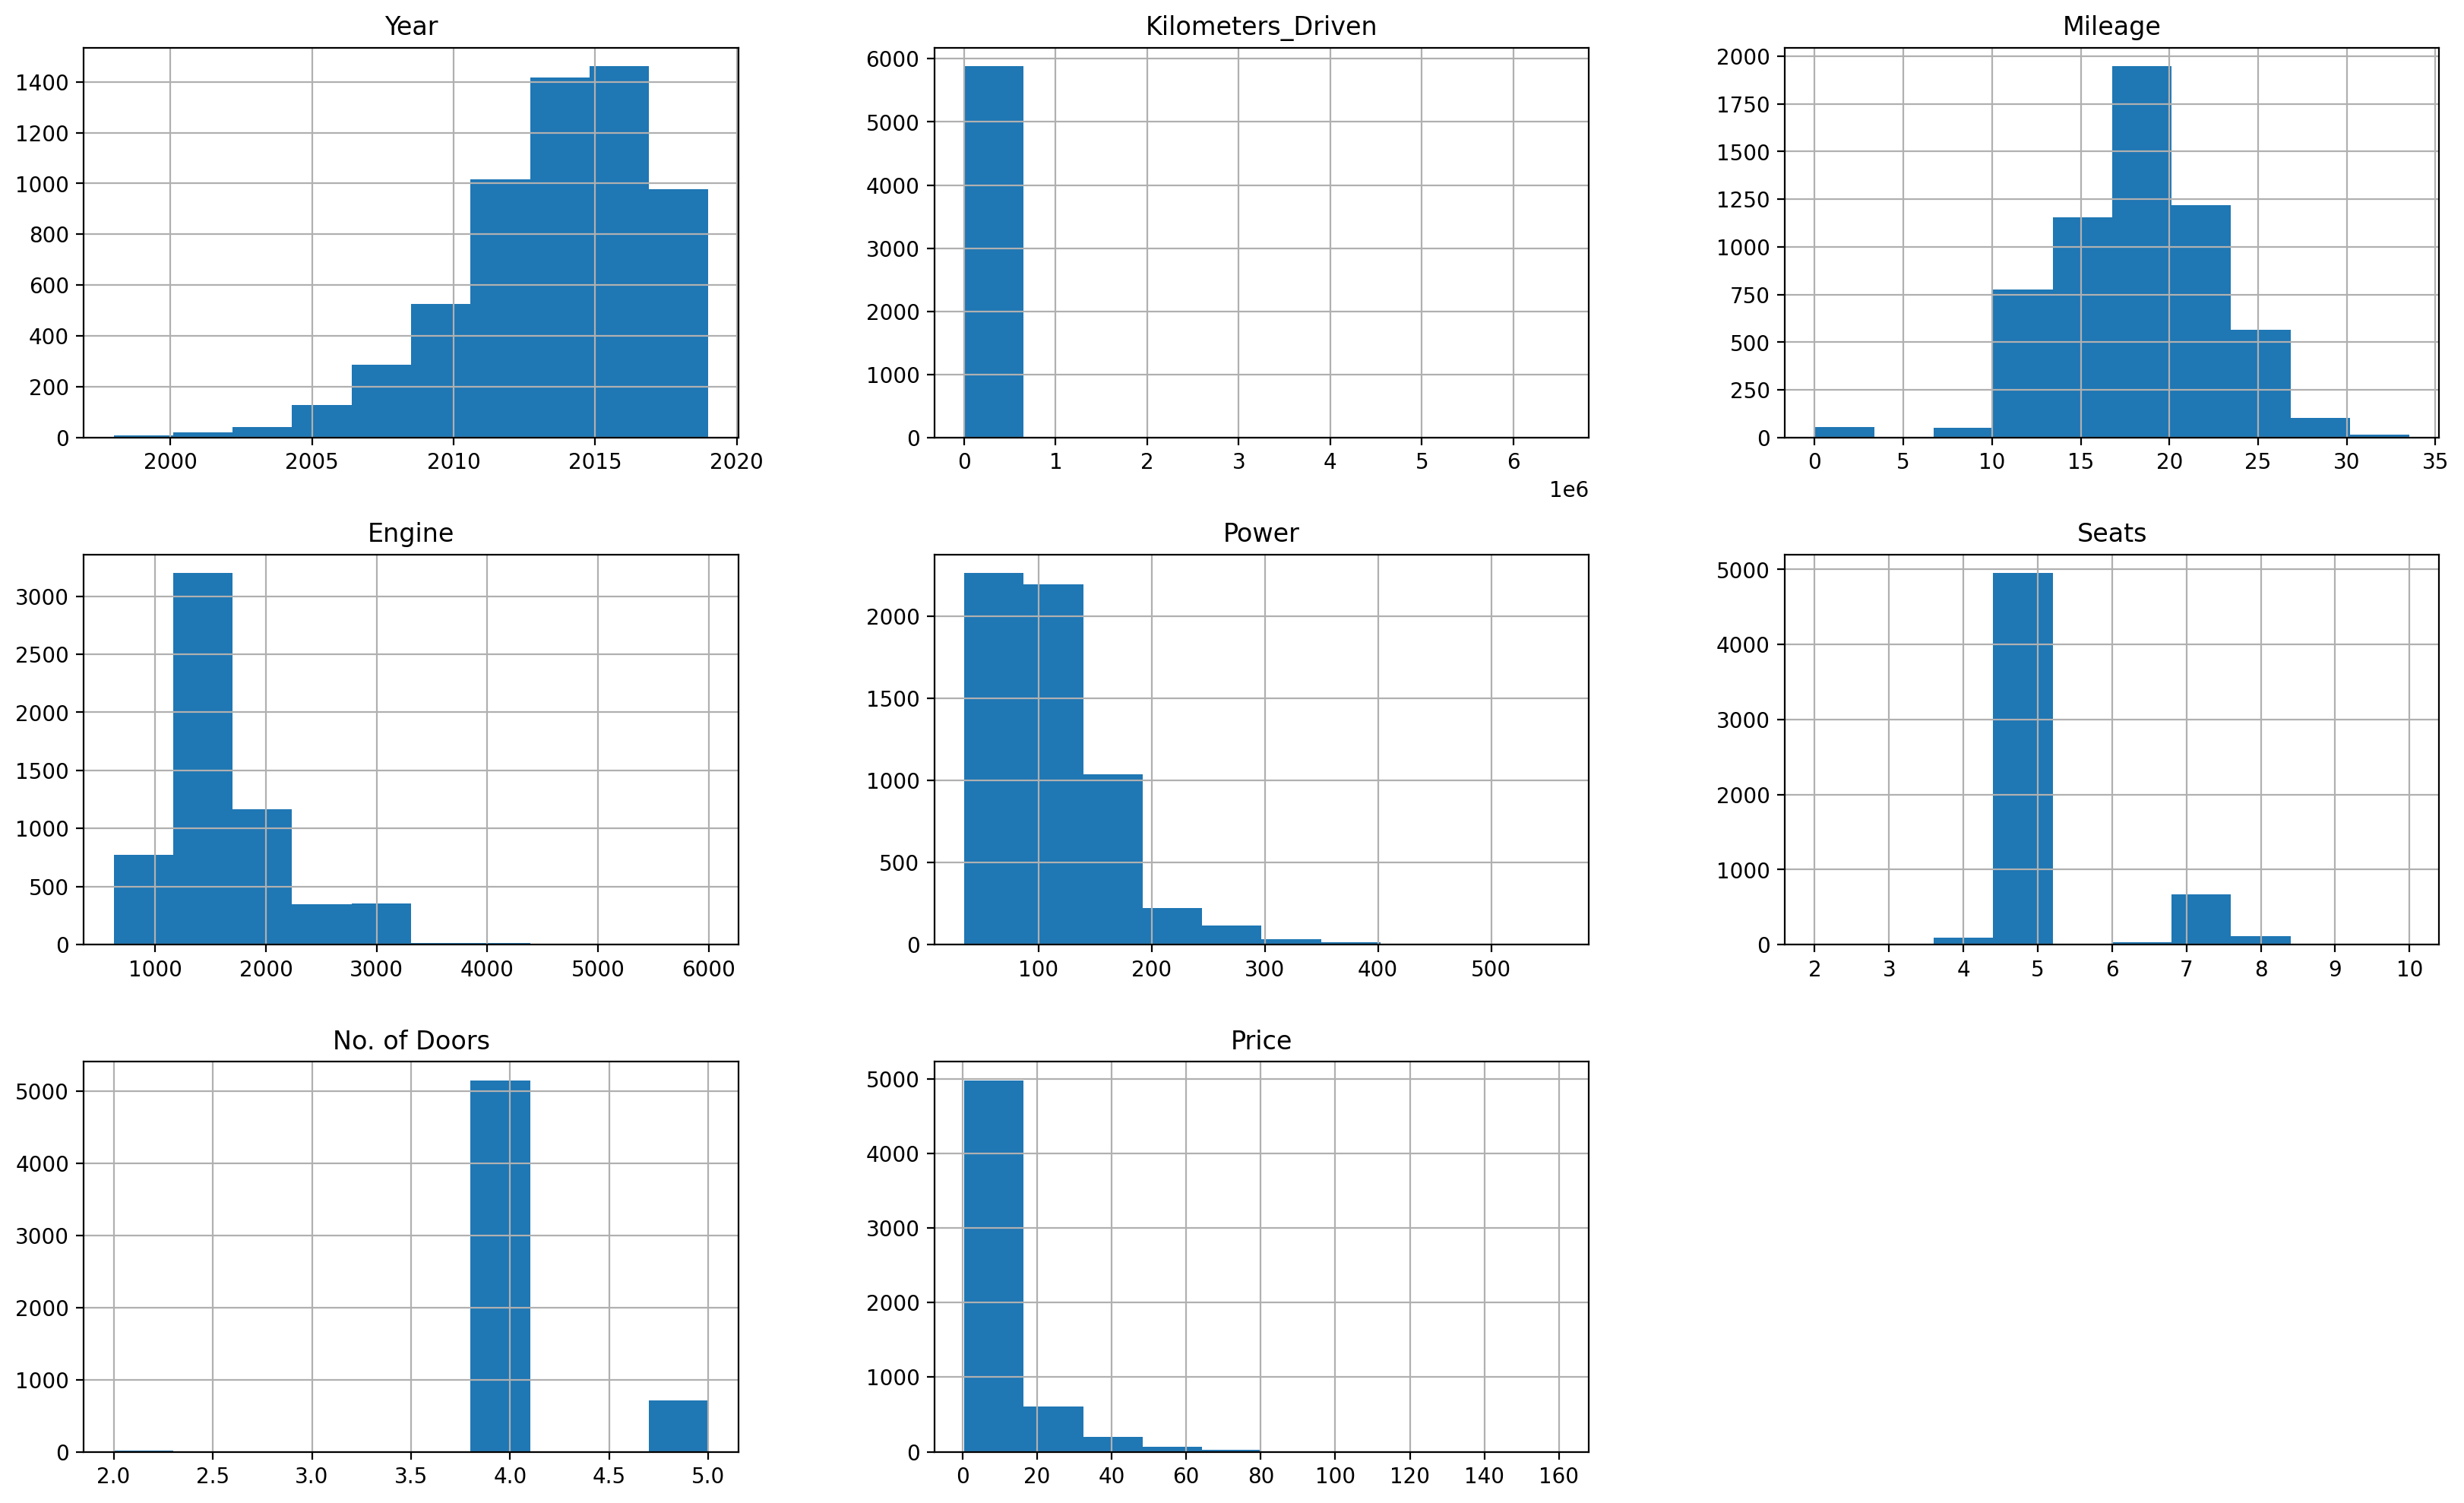

In [14]:
plt.rcParams["figure.figsize"] = (20, 12)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 10
df.hist()

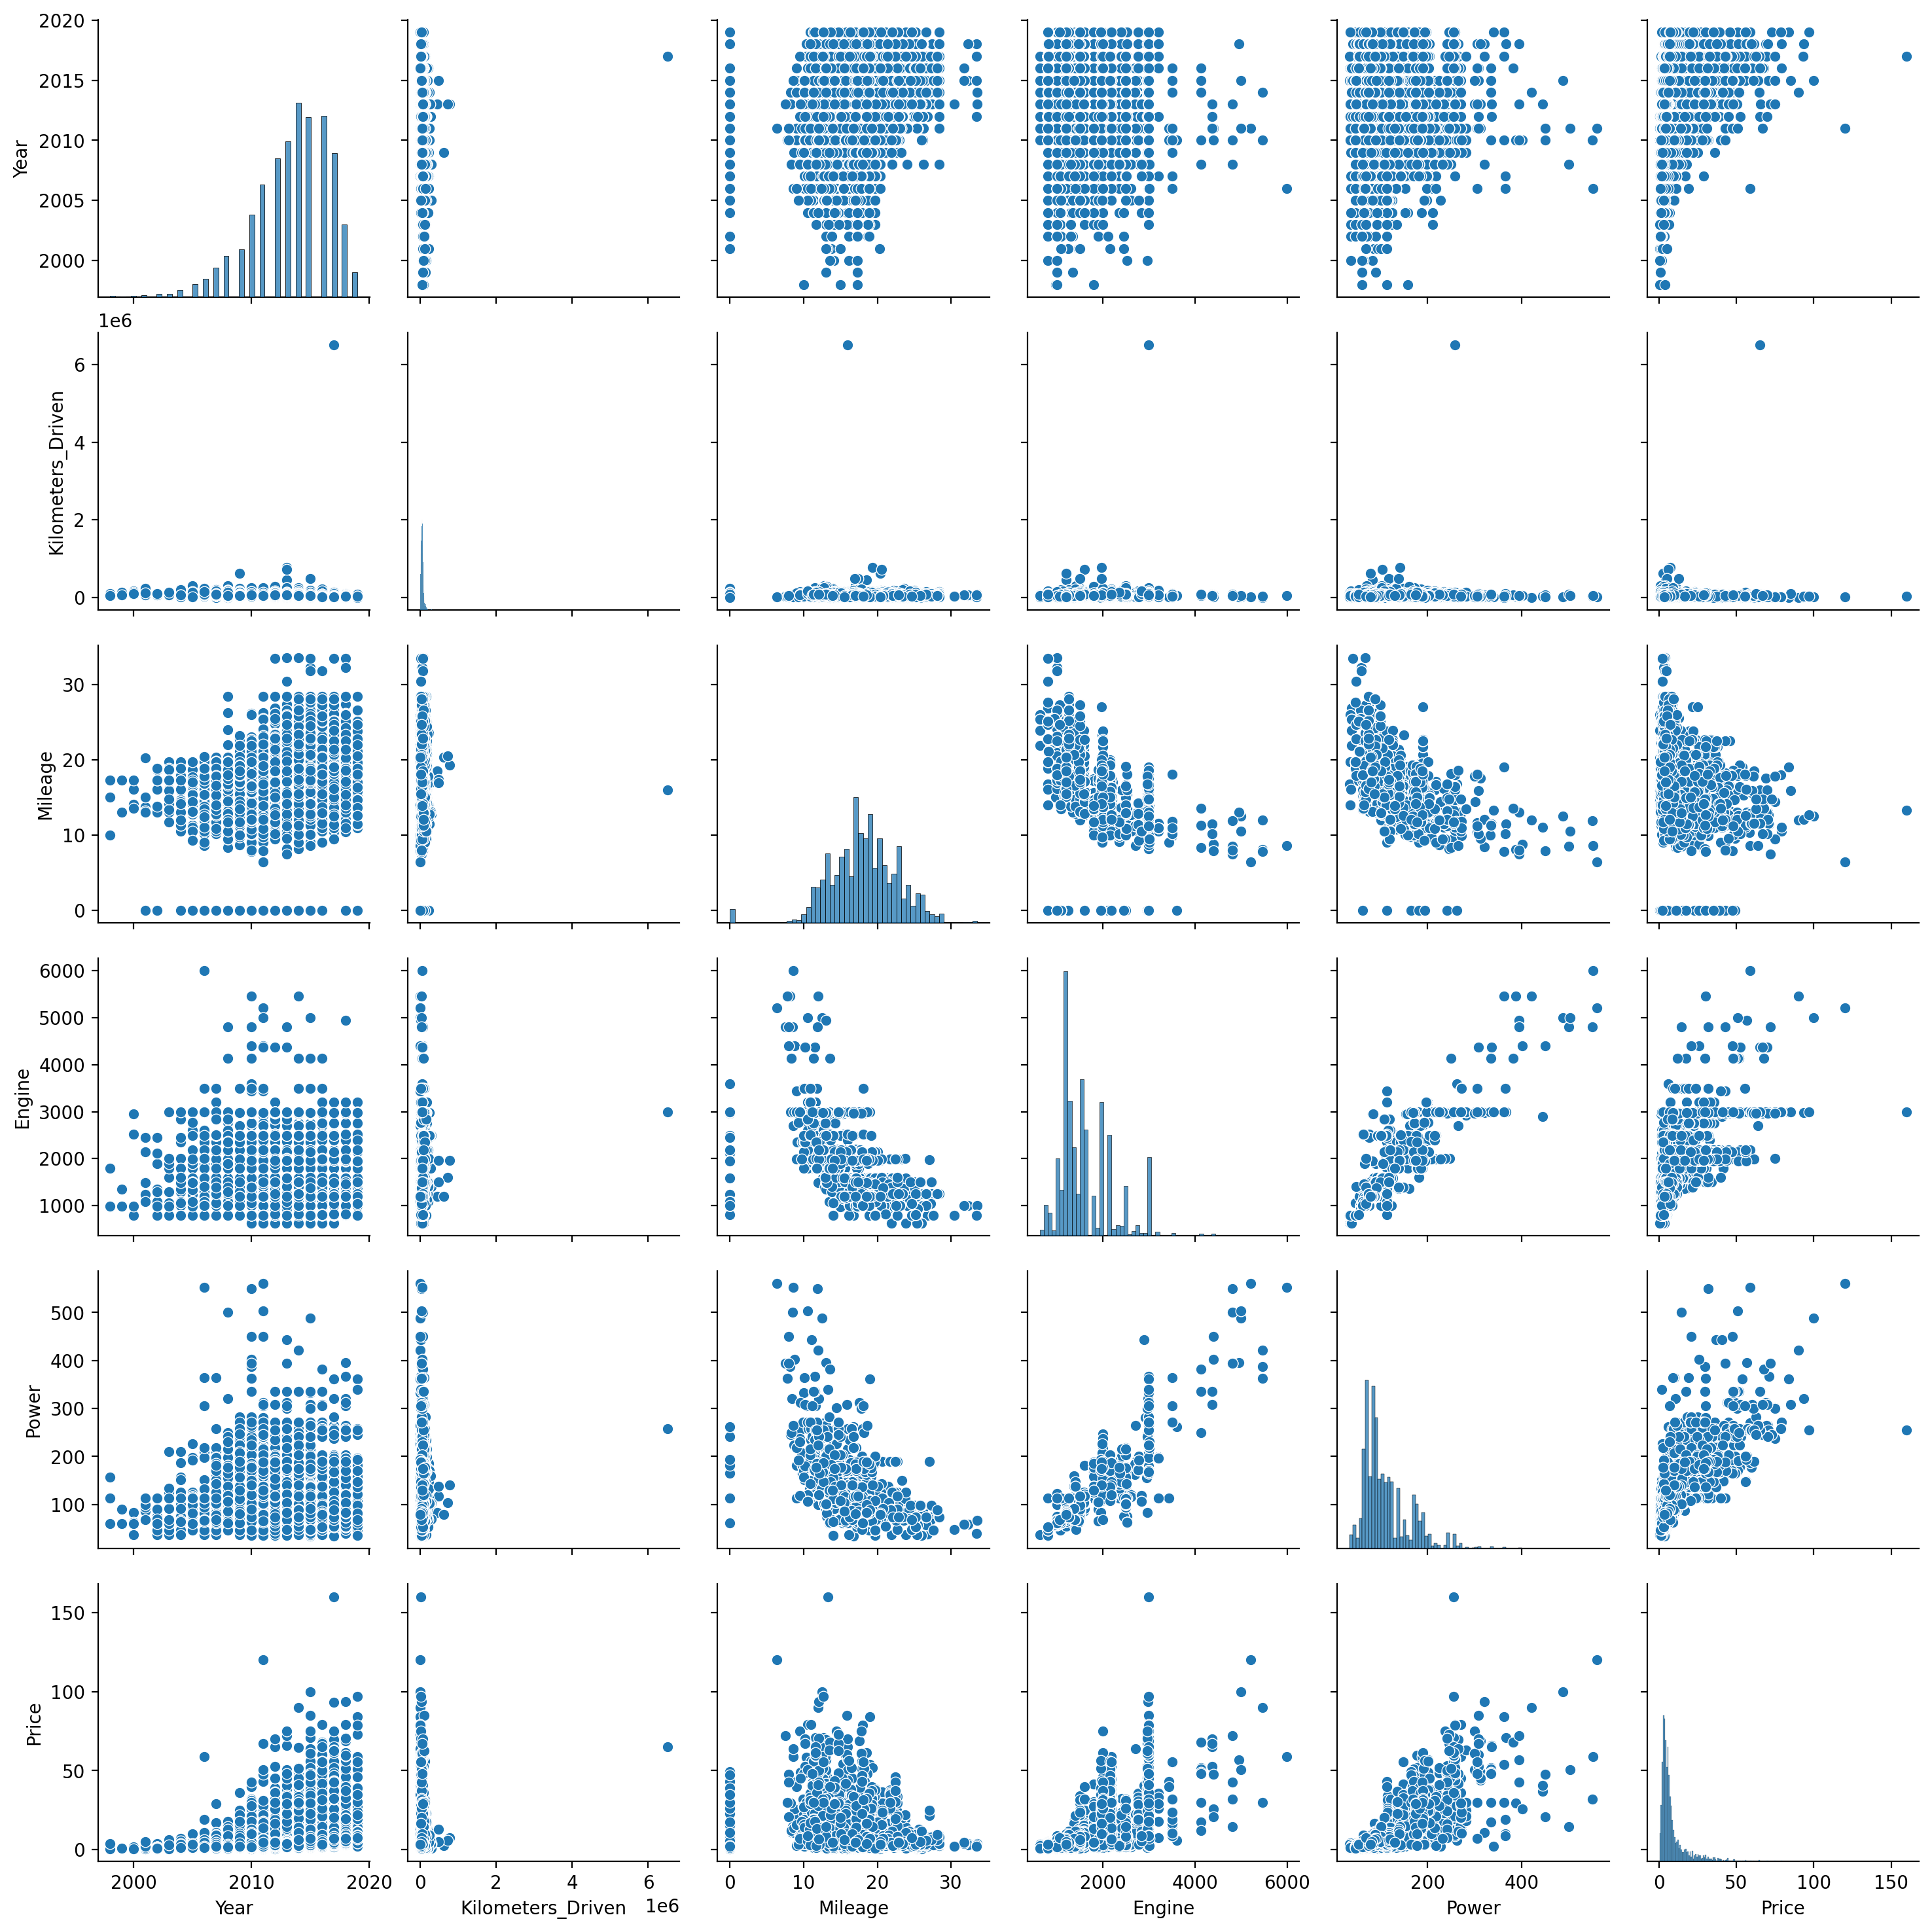

In [15]:
cont_cols_ = ["Year", "Kilometers_Driven", "Mileage", "Engine", "Power", "Price"]
plt.rcParams["figure.figsize"] = (20, 12)
sns.pairplot(df[cont_cols_])
plt.show()

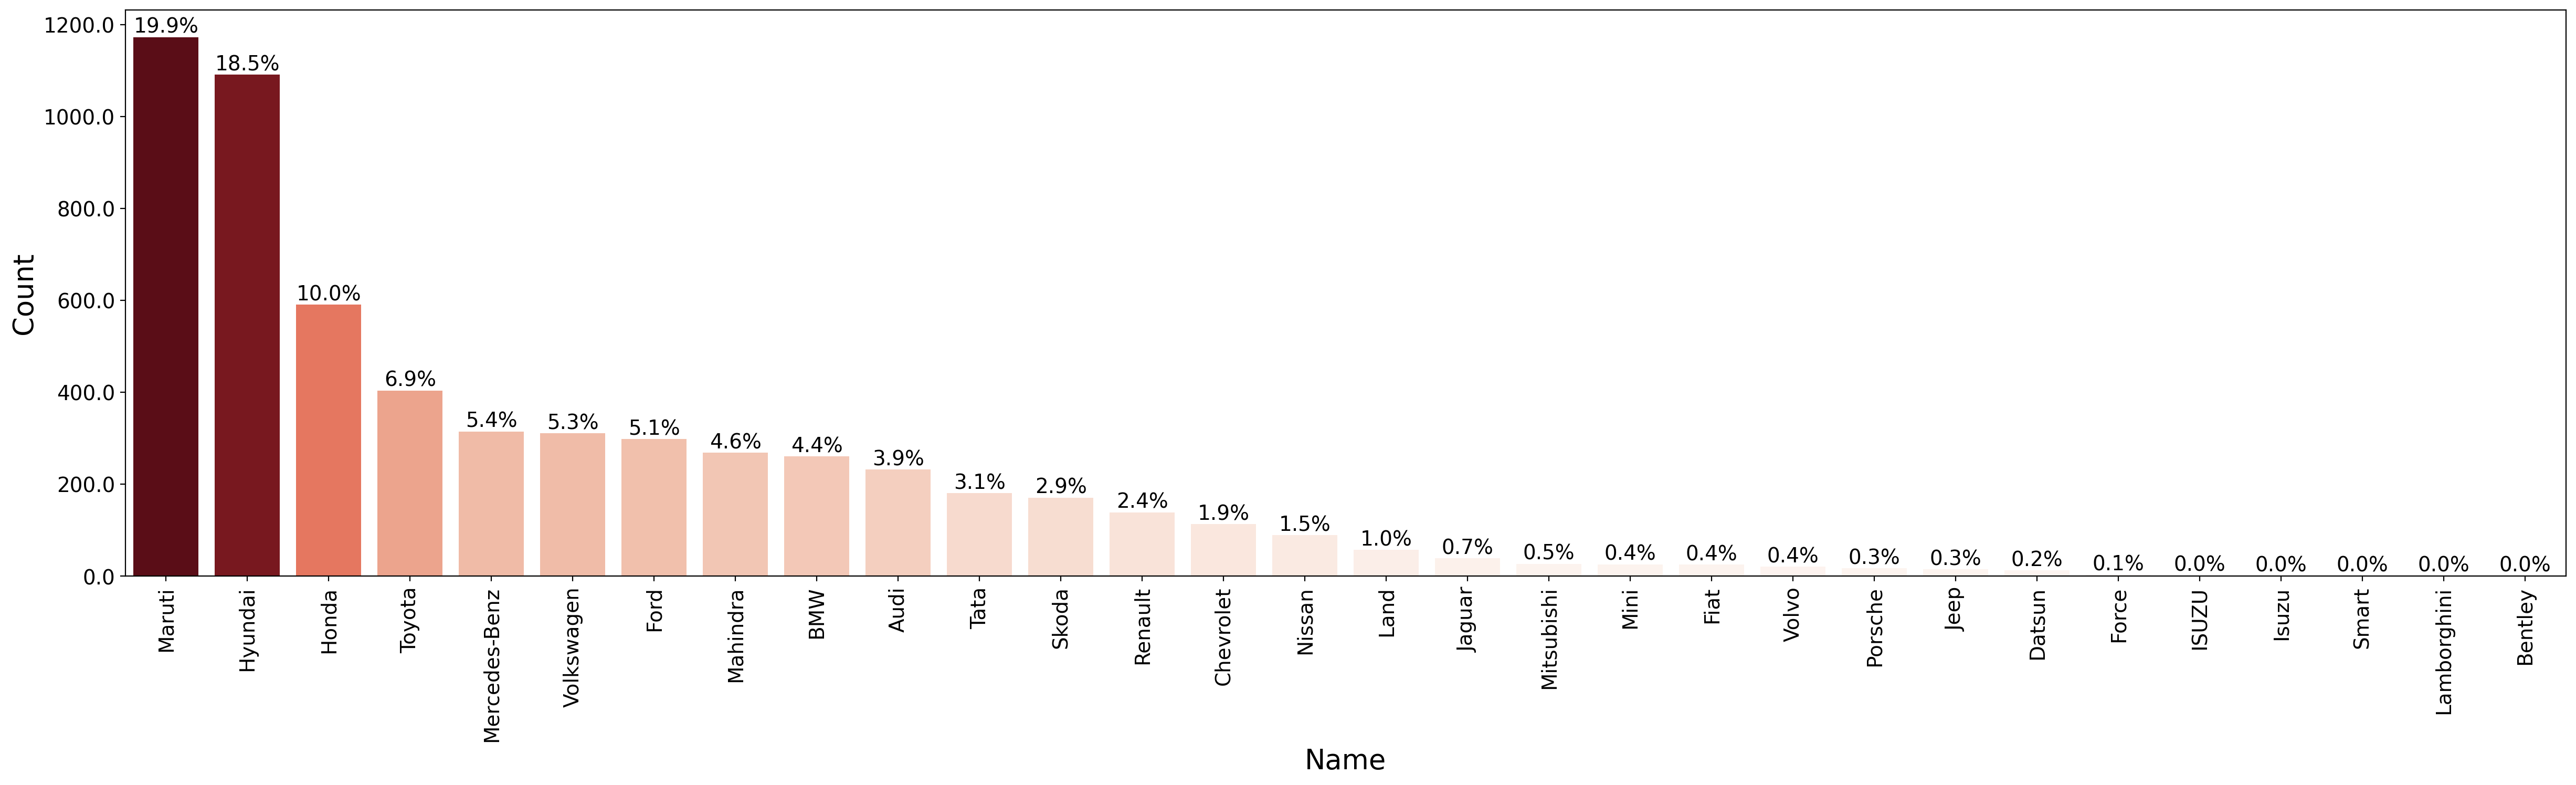

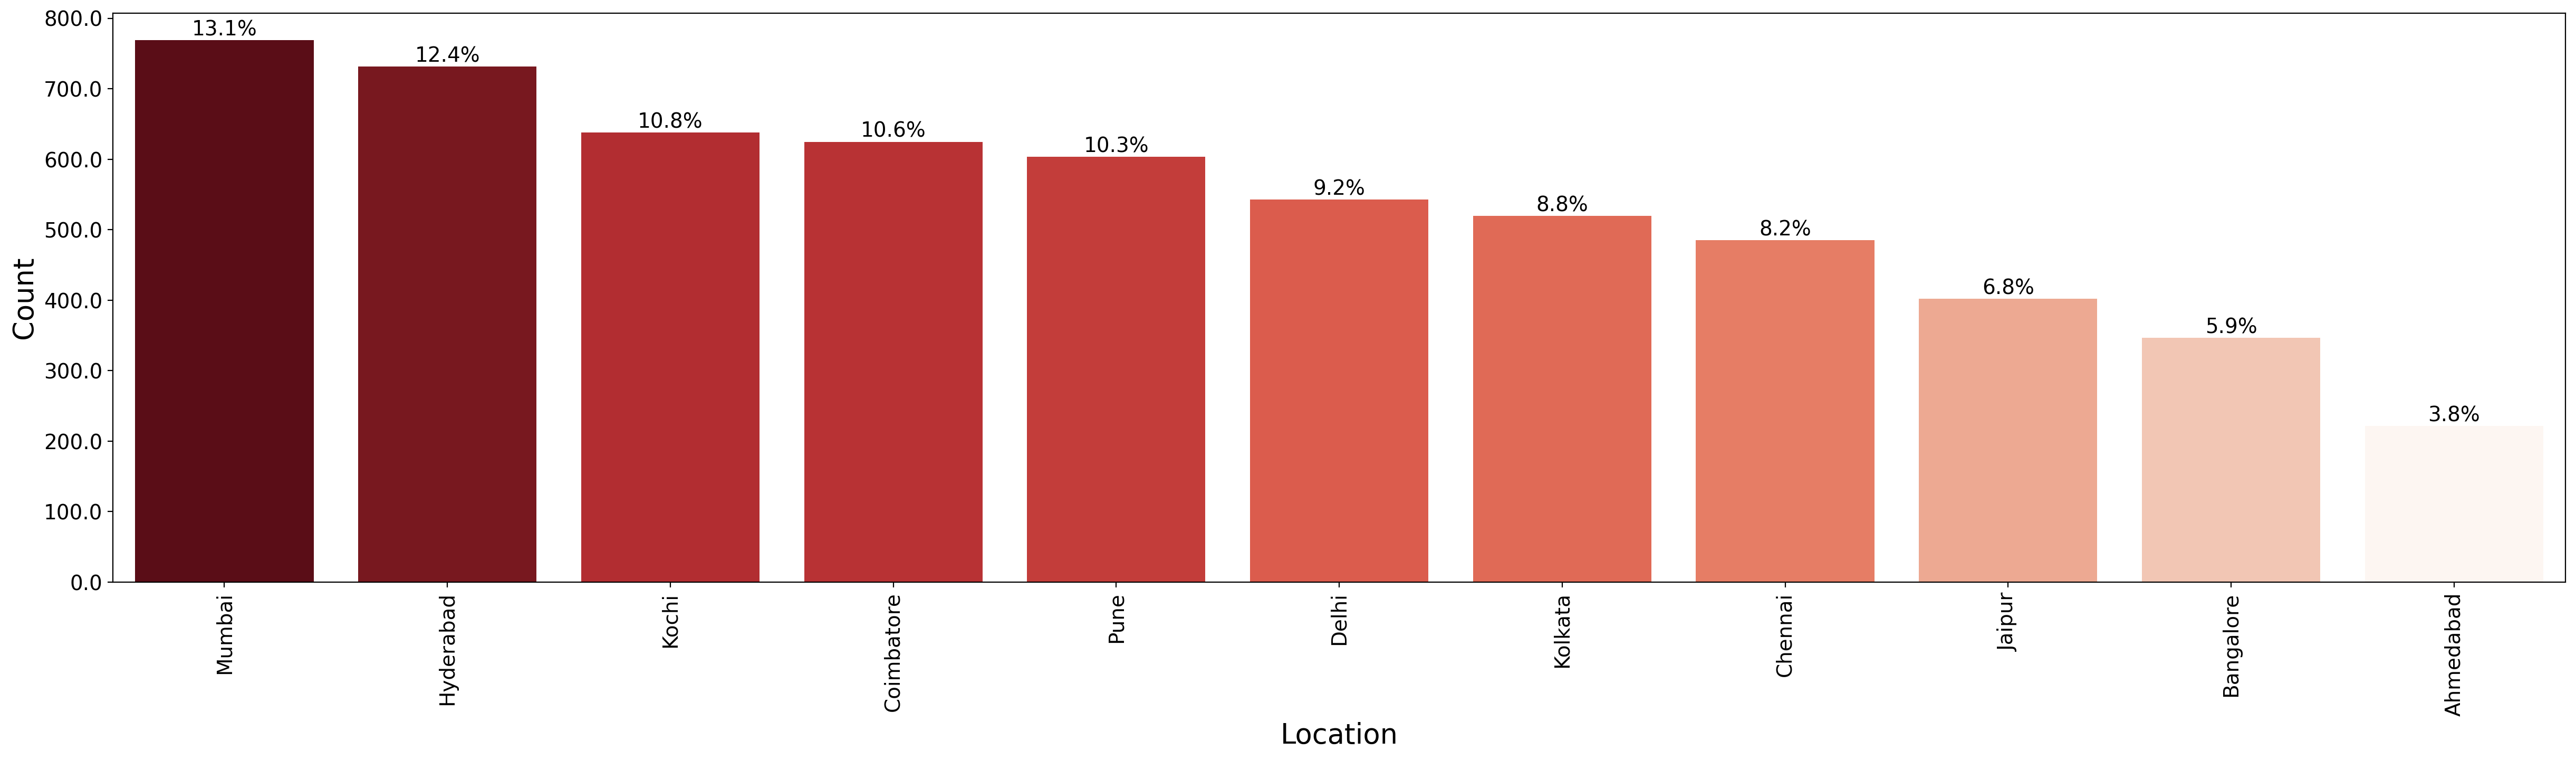

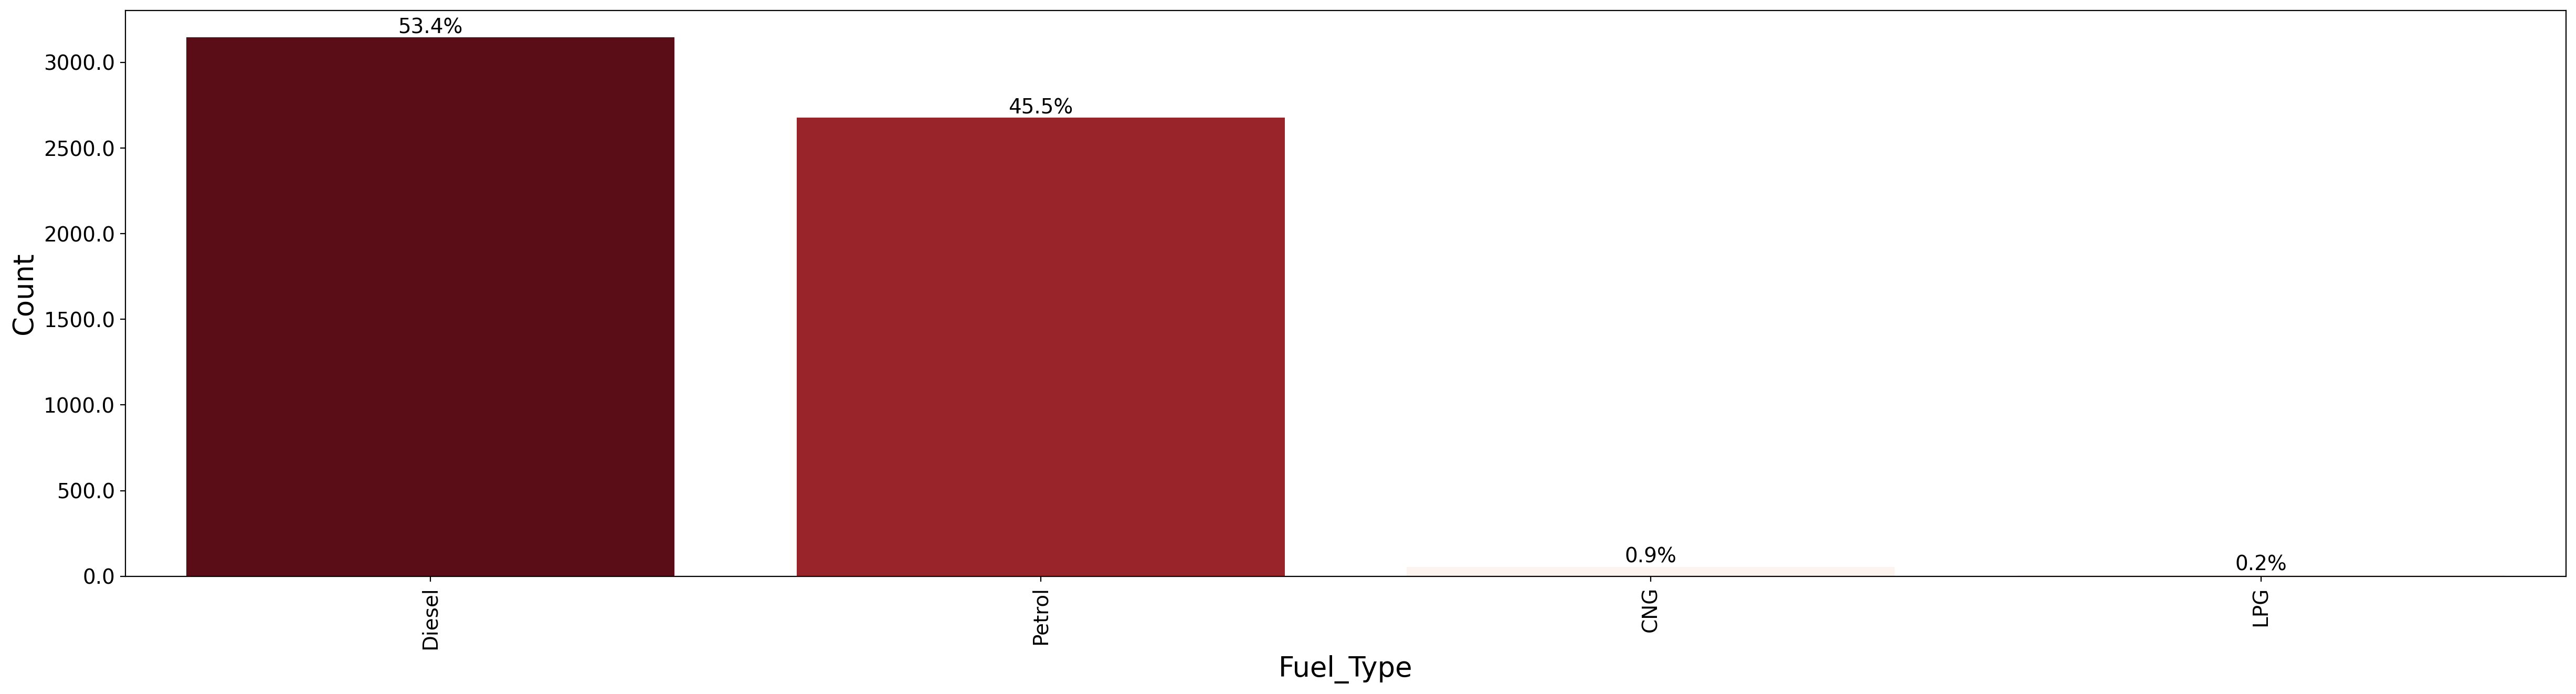

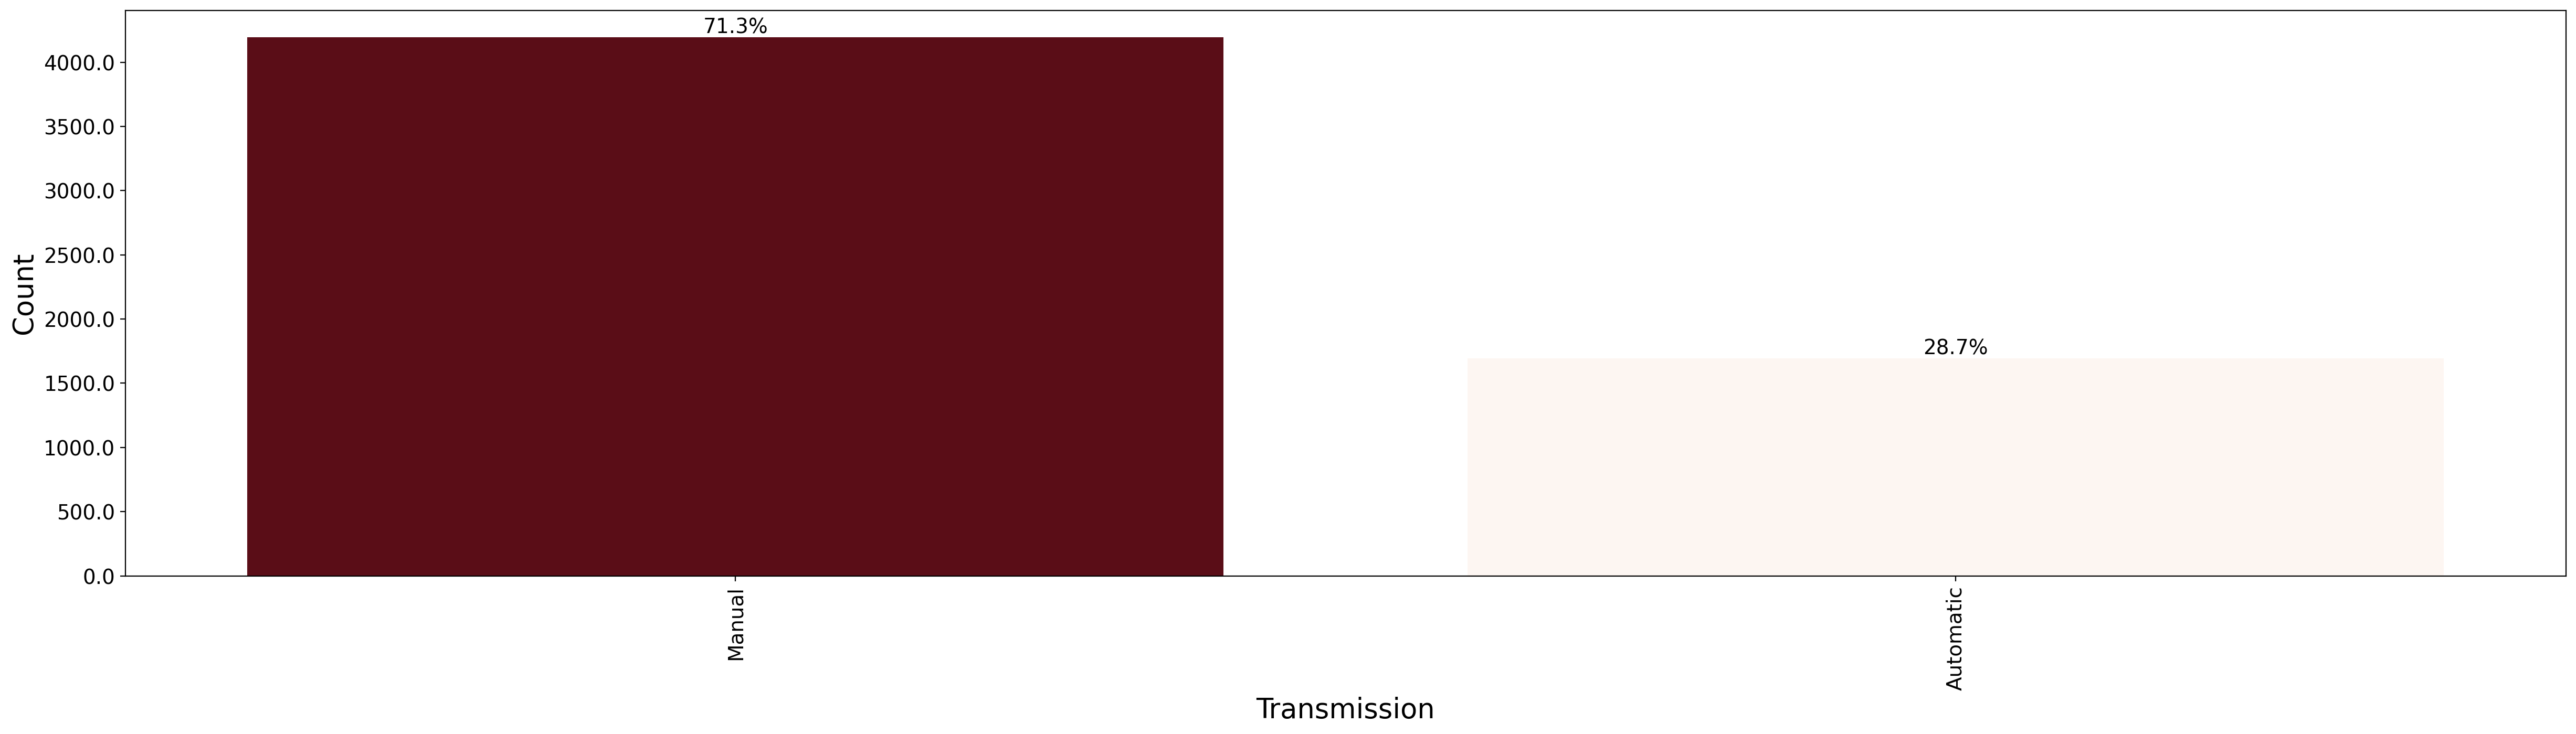

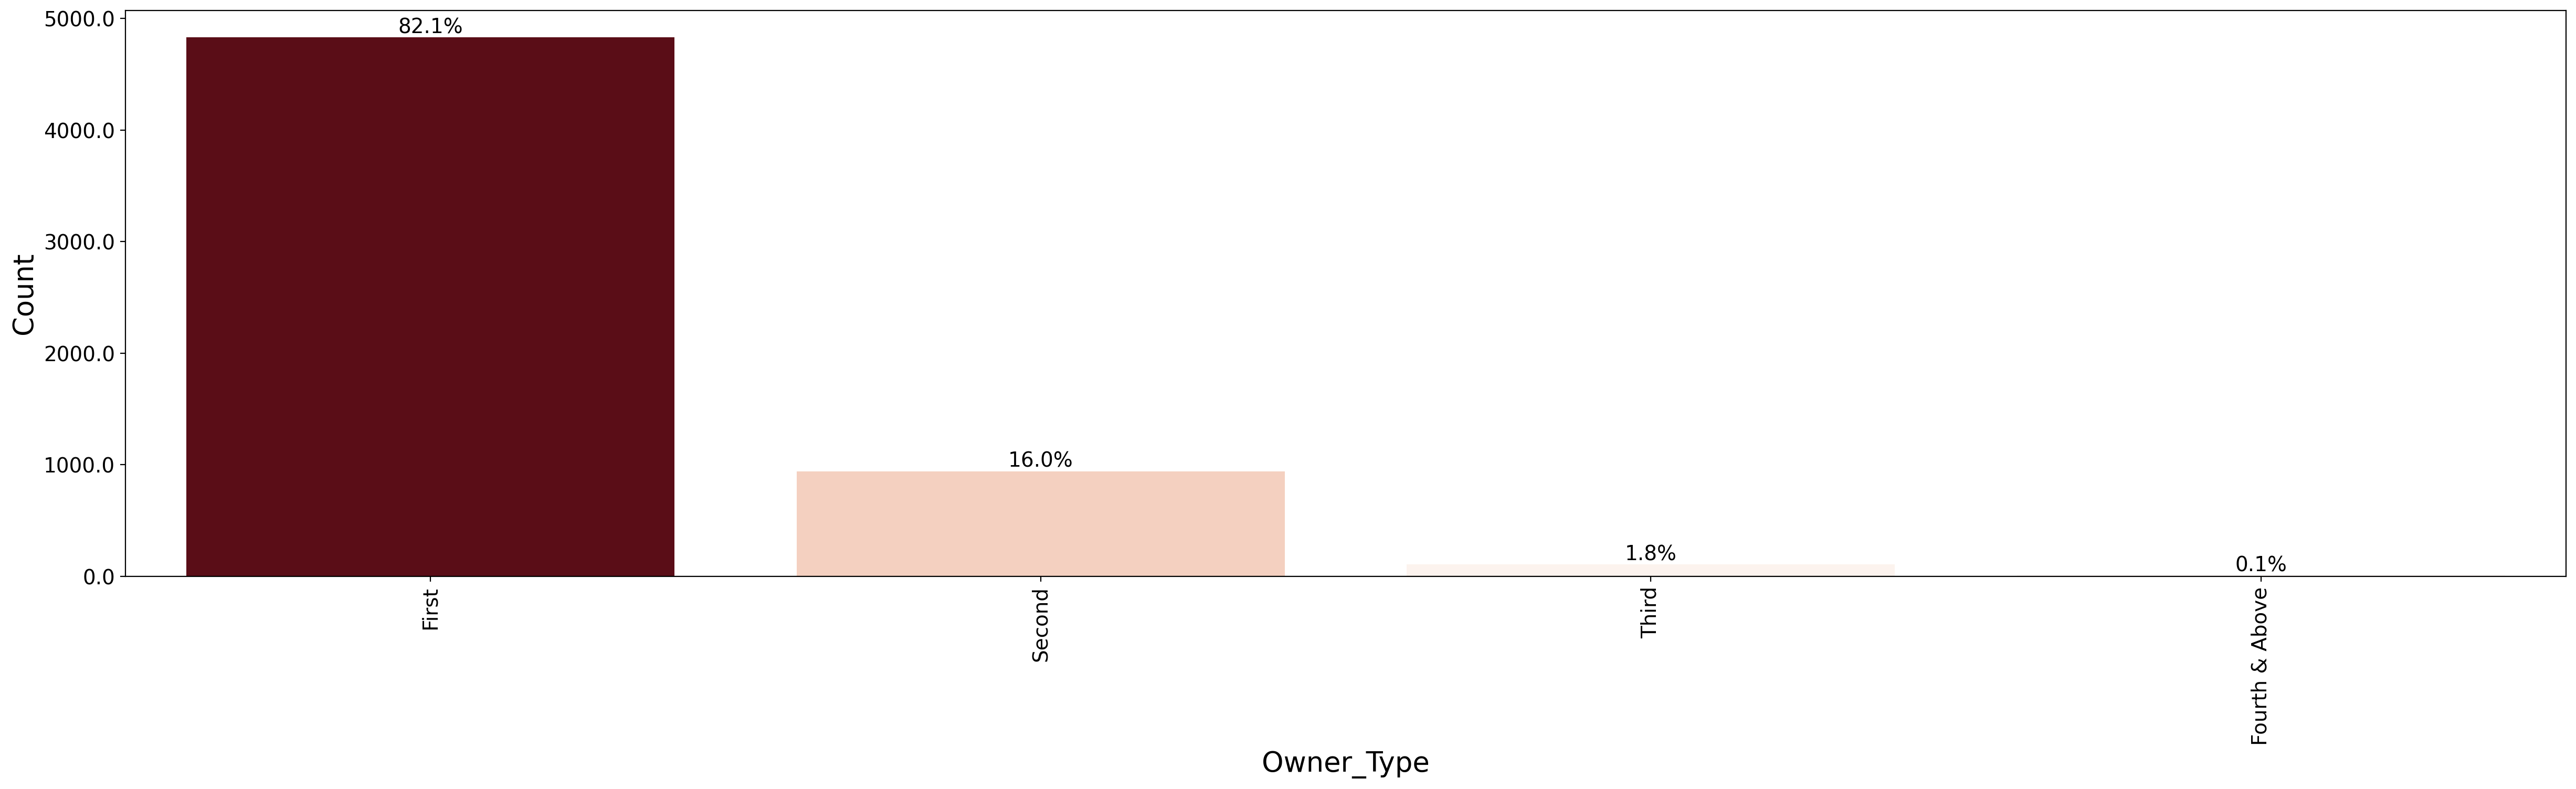

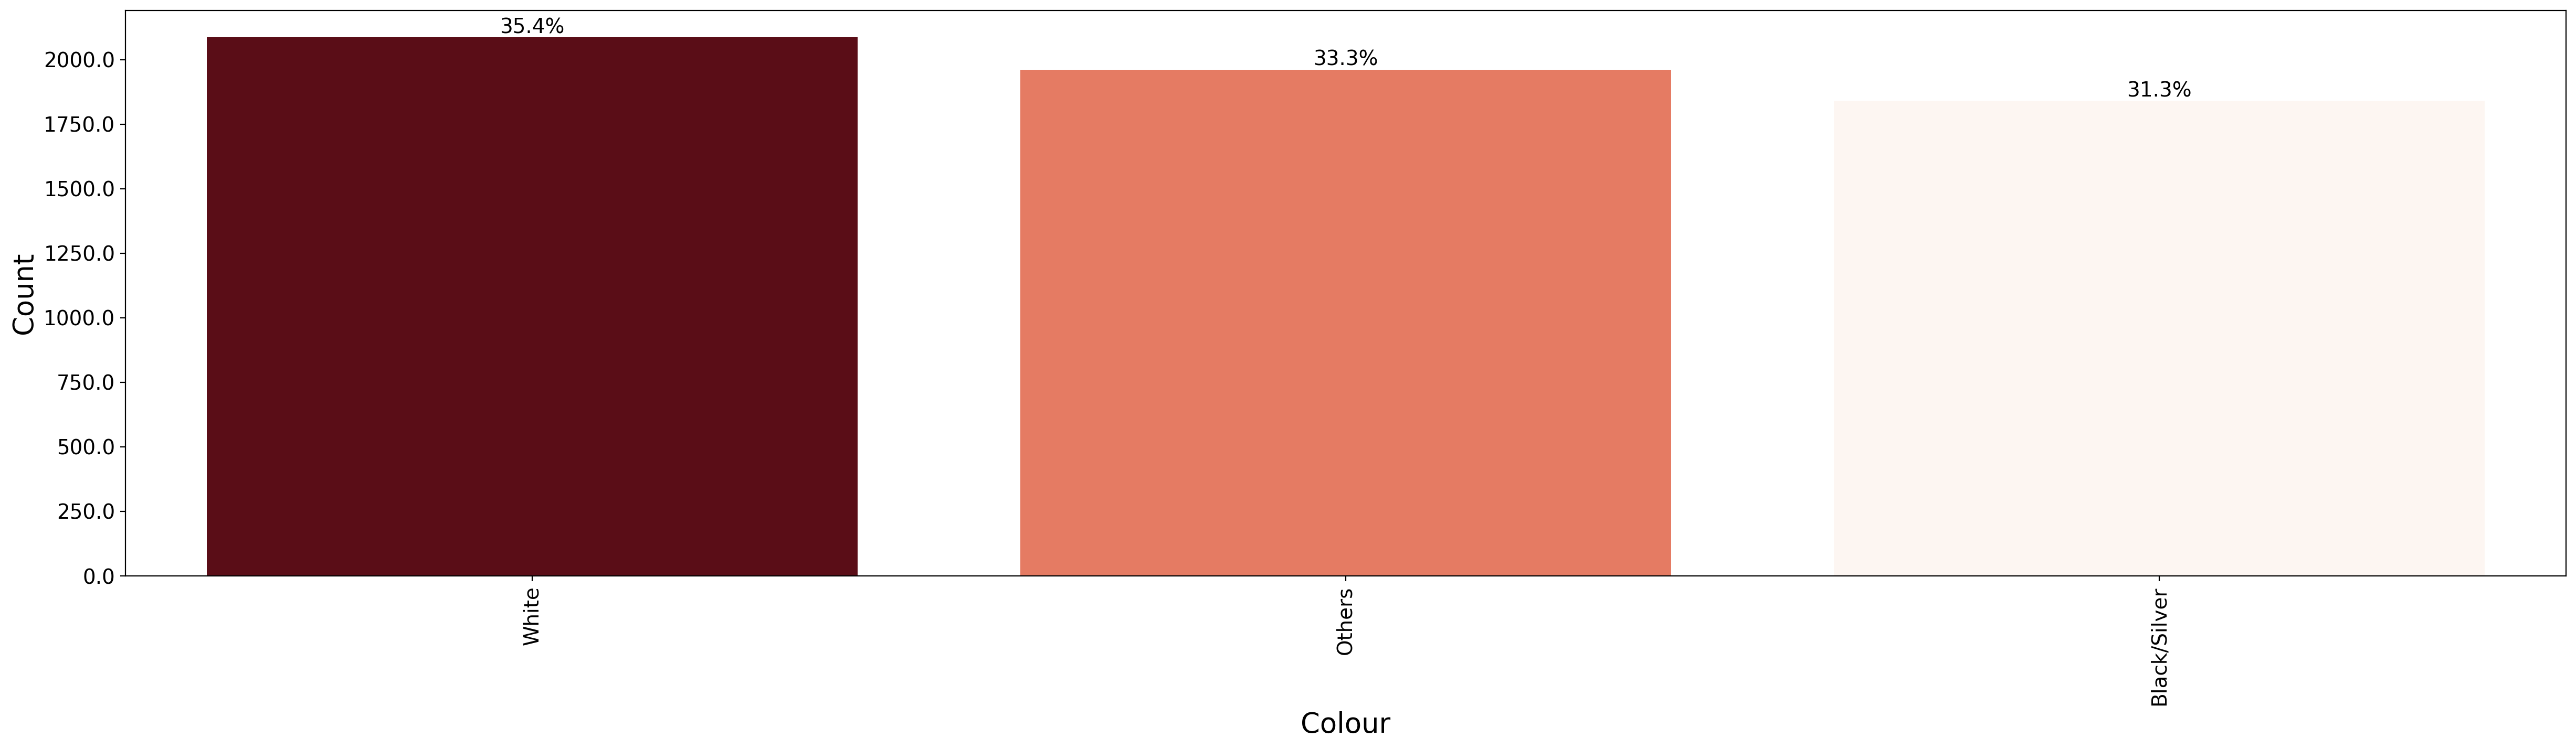

In [16]:
cat_cols = df.select_dtypes(include=['object']).columns
for c in cat_cols:
    plot_category_distribution(df, c, figsize=(30, 7), labelsize=14)

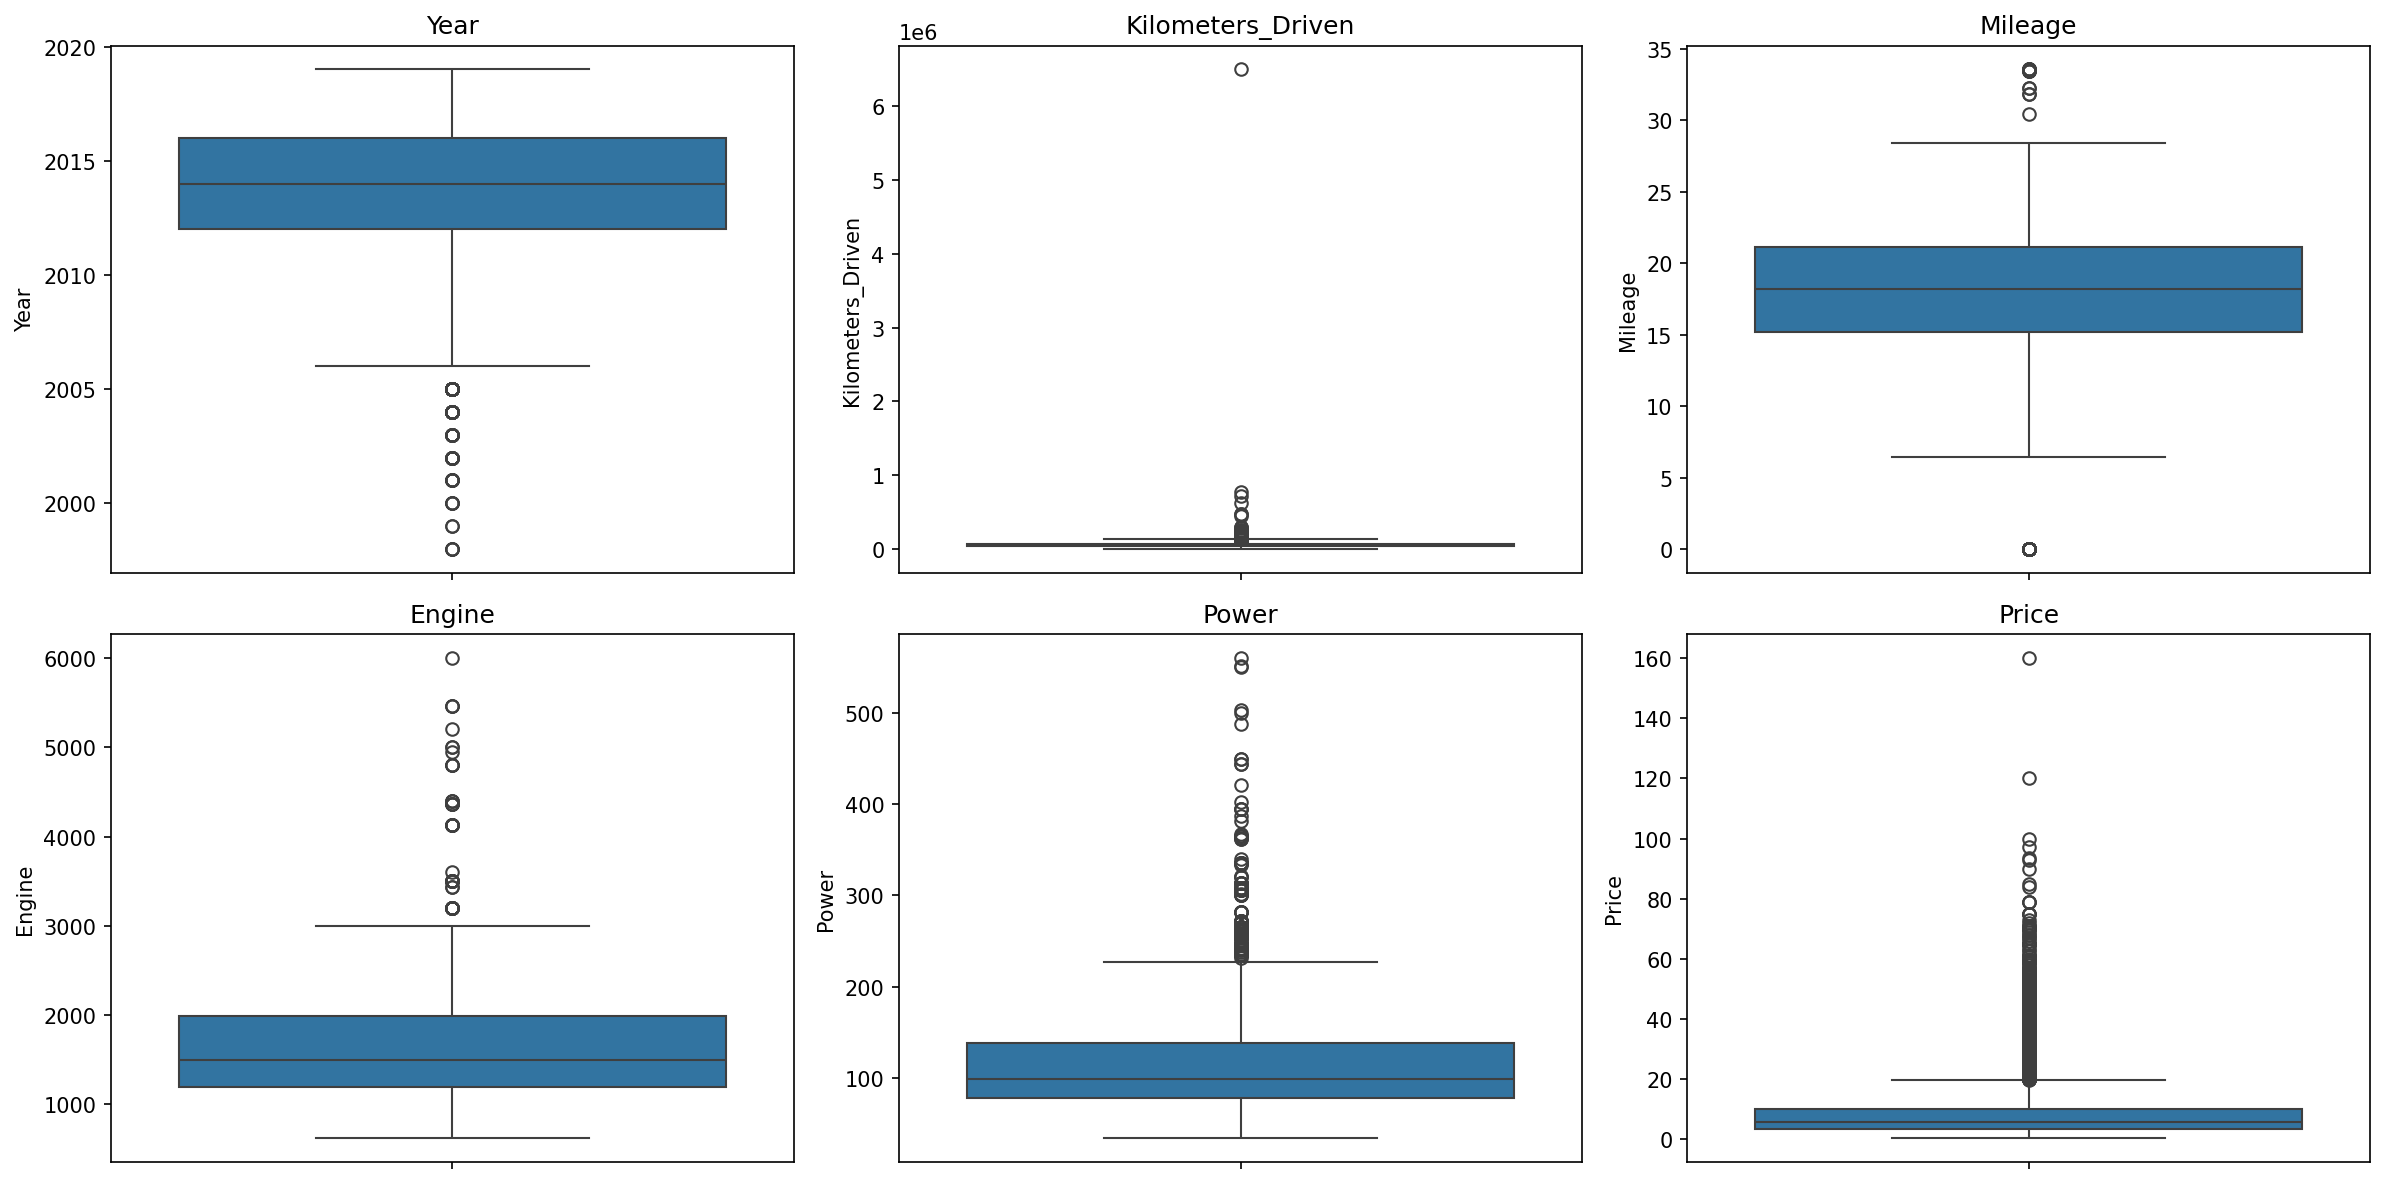

Tổng số outlier trừ cột Seats, No. of Doors là 1094, tỷ lệ 18.58%


In [17]:
# cont_cols_: Kilometers_Driven, Mileage, Engine, Power, Price
cont_cols_ = ["Year", "Kilometers_Driven", "Mileage", "Engine", "Power", "Price"]
boxplots(df, cont_cols_, 3)
df_ol = find_outliers(df, cont_cols_)
print(f"Tổng số outlier trừ cột Seats, No. of Doors là {len(df_ol)}, tỷ lệ {round(len(df_ol) / len(df) * 100, 2)}%")

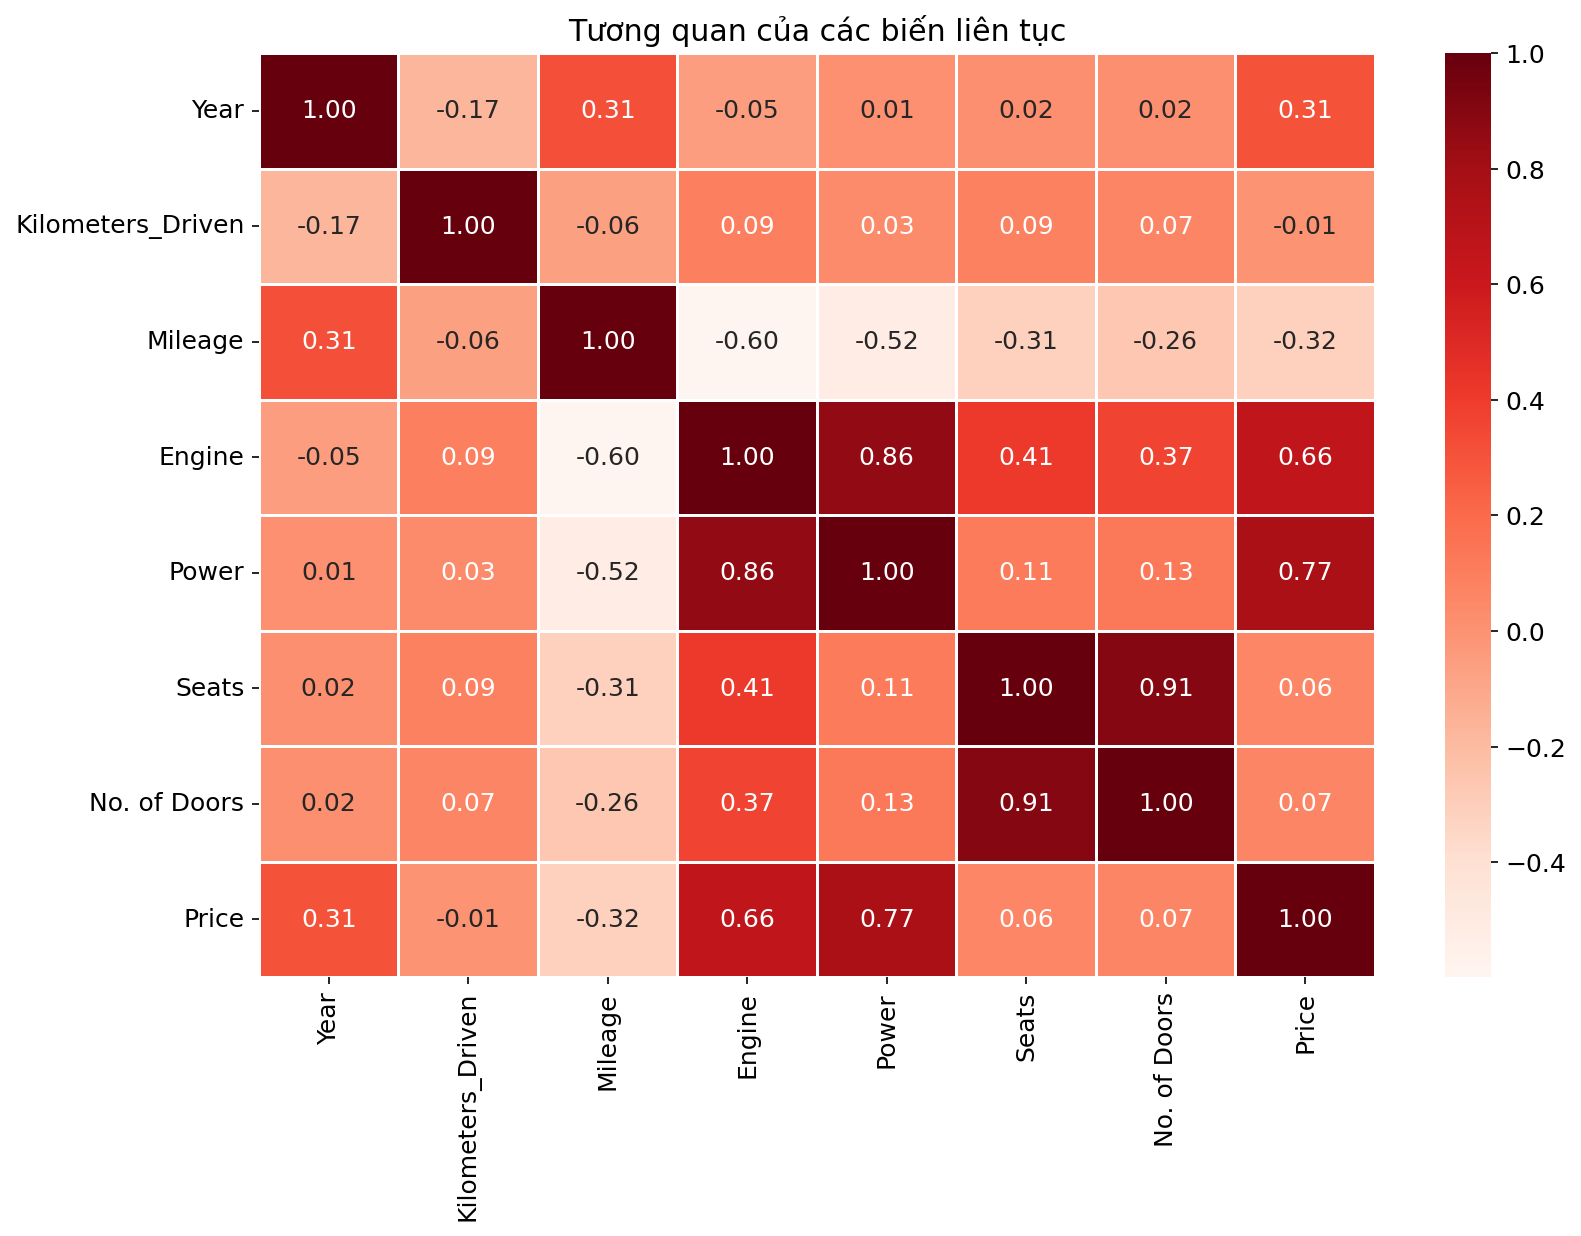

In [18]:
# Kiểm tra tương quan của các biến liên tục
continuous_vars = df.select_dtypes(include=["number"]).columns
corr_matrix = df[continuous_vars].corr()

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.size"] = 12
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Reds", linewidths=0.5)
plt.title("Tương quan của các biến liên tục")
plt.show()

In [19]:
anova_test(df, "Price")

Variable  F-statistic  p-value Impact
0          Name      294.522    0.000    Yes
1      Location       39.094    0.000    Yes
2     Fuel_Type      225.215    0.000    Yes
3  Transmission     3062.236    0.000    Yes
4    Owner_Type       18.868    0.000    Yes
5        Colour        0.203    0.816     No

## Xử lý outlier

### Year

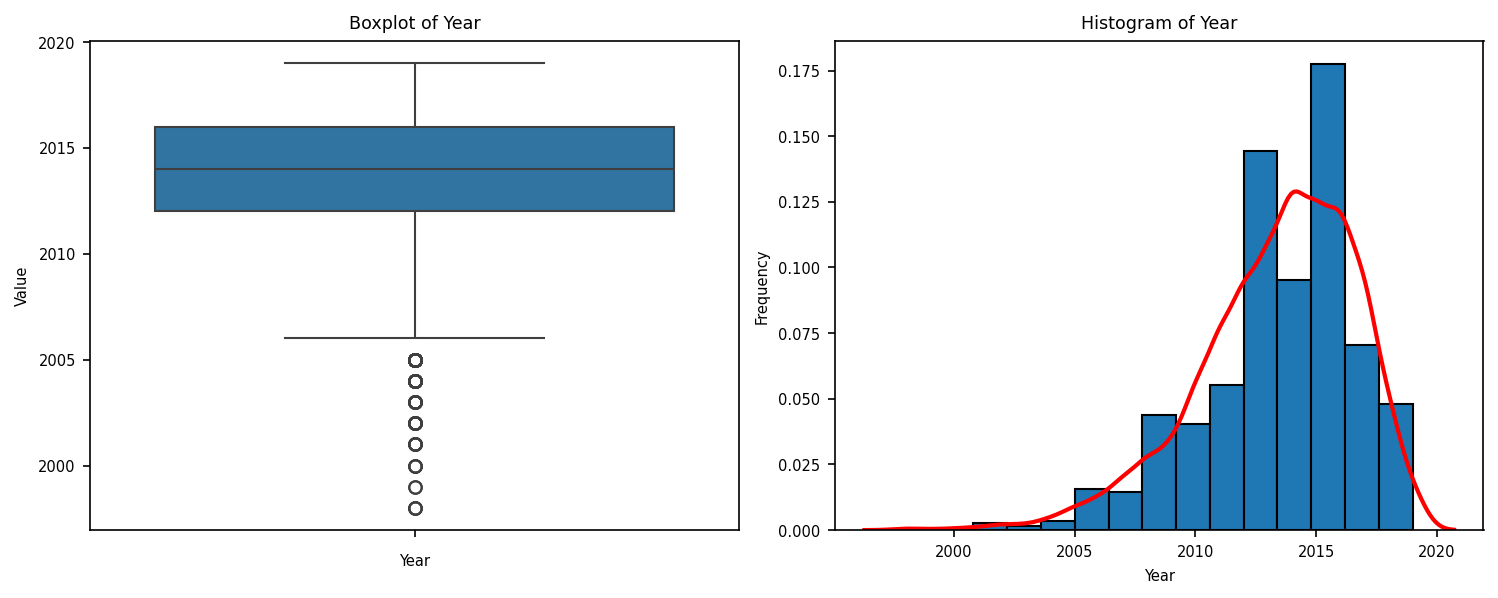

Tổng quan về outlier của cột Year
Số lượng outlier: 126
Khoảng outlier: [1998.0, 2006.0)
Tỷ lệ % của outlier so với tập dữ liệu: 2.14%
Tổng số outlier trong cột < 2002: 17 chiếm tỷ lệ 13.49%


In [20]:
box_hist(df, "Year")
col_outlier, range_outlier = count_outliers_col(df, "Year")
overview_outliers(df, col_outlier, "Year", range_outlier)

value = 2002
count = (col_outlier["Year"] < value).sum()
per = count / len(col_outlier)
print(f"Tổng số outlier trong cột < {value}: {count} chiếm tỷ lệ {round(per * 100, 2)}%")

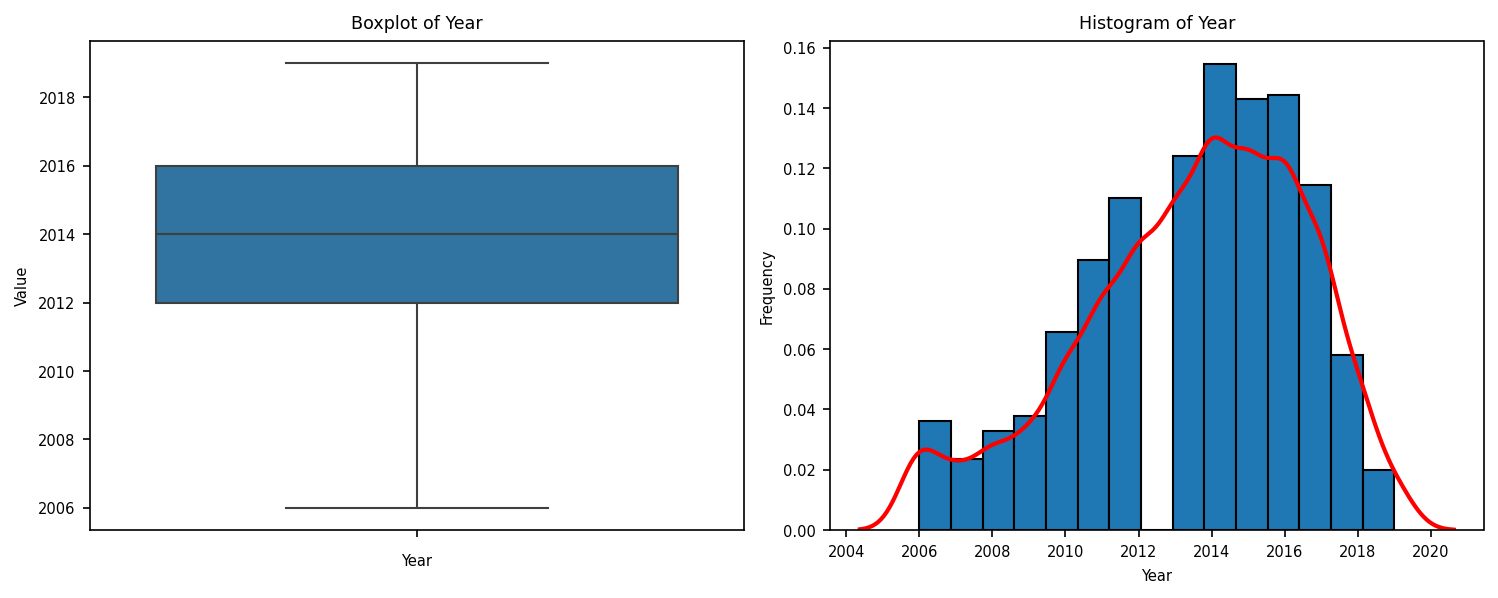

Tổng quan về outlier của cột Year
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [21]:
df = df.drop(df[df["Year"] < 2002].index).reset_index(drop=True)
df["Year"] = df["Year"].clip(lower=2006)

box_hist(df, "Year")
col_outlier, range_outlier = count_outliers_col(df, "Year")
overview_outliers(df, col_outlier, "Year", range_outlier)

### Kilometers_Driven

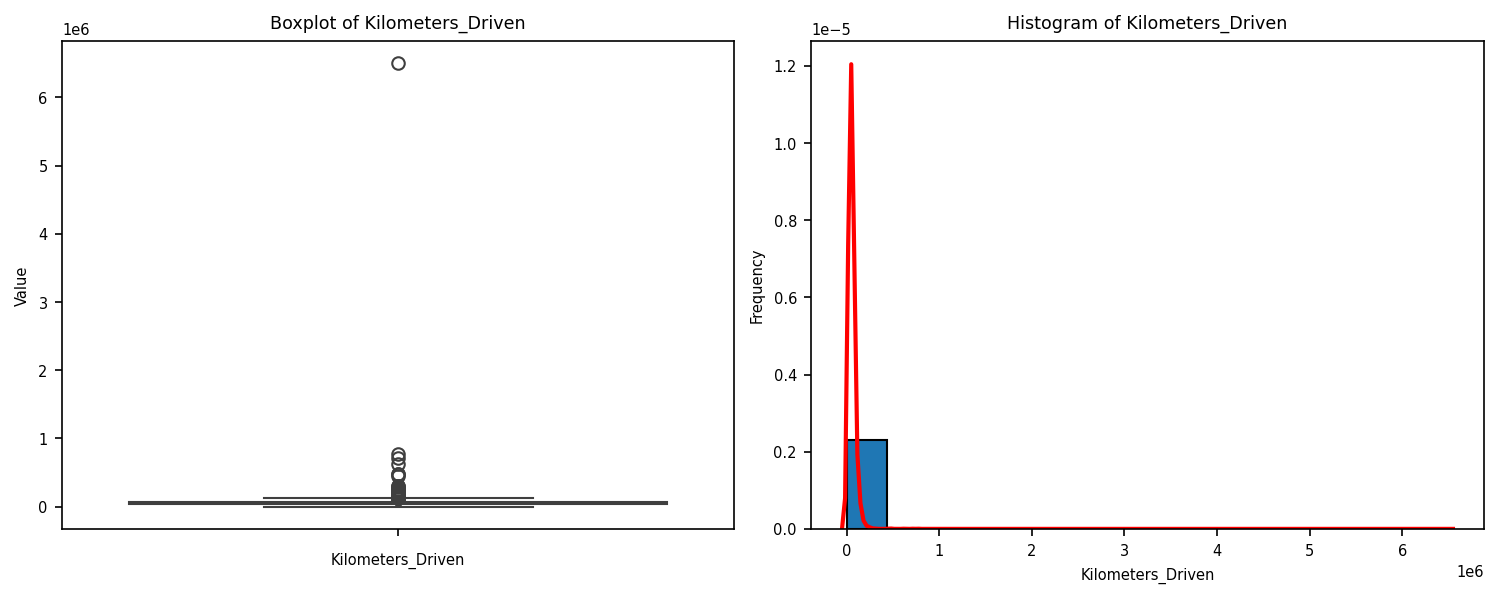

Tổng quan về outlier của cột Kilometers_Driven
Số lượng outlier: 195
Khoảng outlier: (131901.0, 6500000.0]
Tỷ lệ % của outlier so với tập dữ liệu: 3.32%
Tổng số outlier trong cột > 190000: 42 chiếm tỷ lệ 21.54%


In [22]:
box_hist(df, "Kilometers_Driven")
col_outlier, range_outlier = count_outliers_col(df, "Kilometers_Driven")
overview_outliers(df, col_outlier, "Kilometers_Driven", range_outlier)

value = 190000
count = (col_outlier["Kilometers_Driven"] > value).sum()
per = count / len(col_outlier)
print(f"Tổng số outlier trong cột > {value}: {count} chiếm tỷ lệ {round(per * 100, 2)}%")

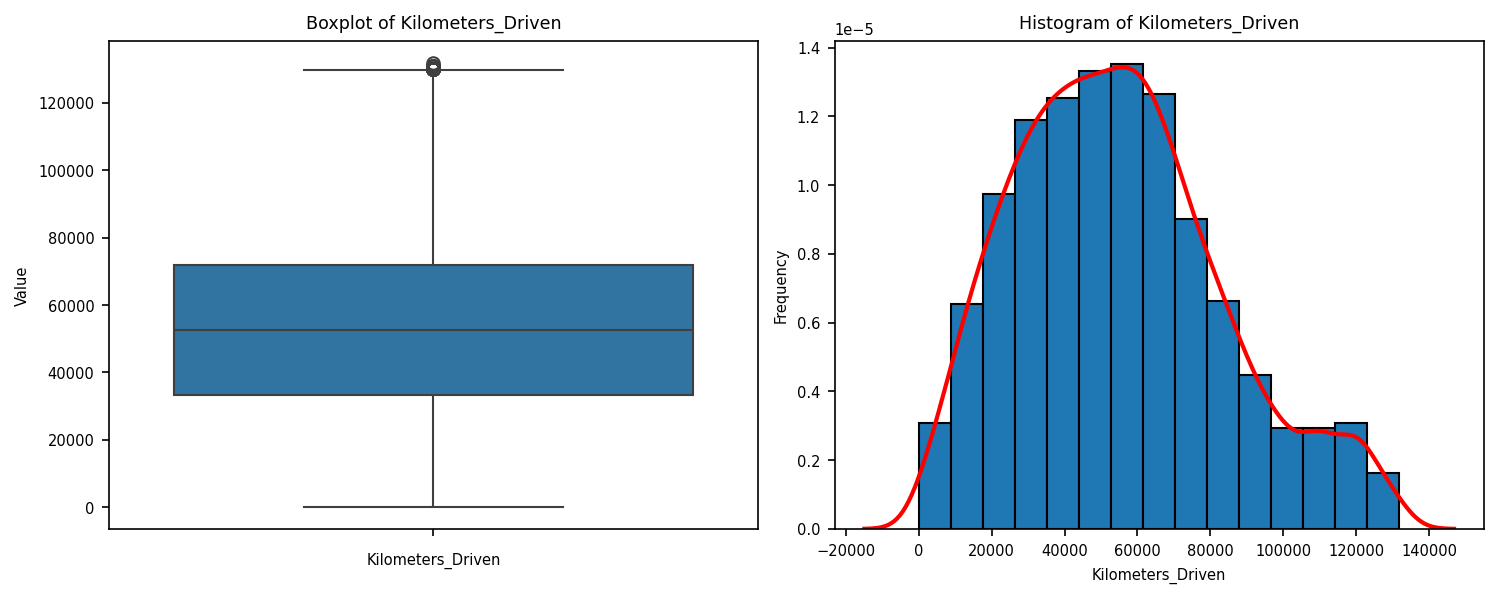

Tổng quan về outlier của cột Kilometers_Driven
Số lượng outlier: 35
Khoảng outlier: (129868.12, 131765.0]
Tỷ lệ % của outlier so với tập dữ liệu: 0.6%


In [23]:
df = df.drop(df[df["Kilometers_Driven"] > 190000].index).reset_index(drop=True)
df["Kilometers_Driven"] = df["Kilometers_Driven"].apply(lambda x: 110000 if 131901 <= x < 150000 else
                                                        120000 if 150000 <= x < 175000 else
                                                        130000 if 175000 <= x else x)
box_hist(df, "Kilometers_Driven")
col_outlier, range_outlier = count_outliers_col(df, "Kilometers_Driven")
overview_outliers(df, col_outlier, "Kilometers_Driven", range_outlier)

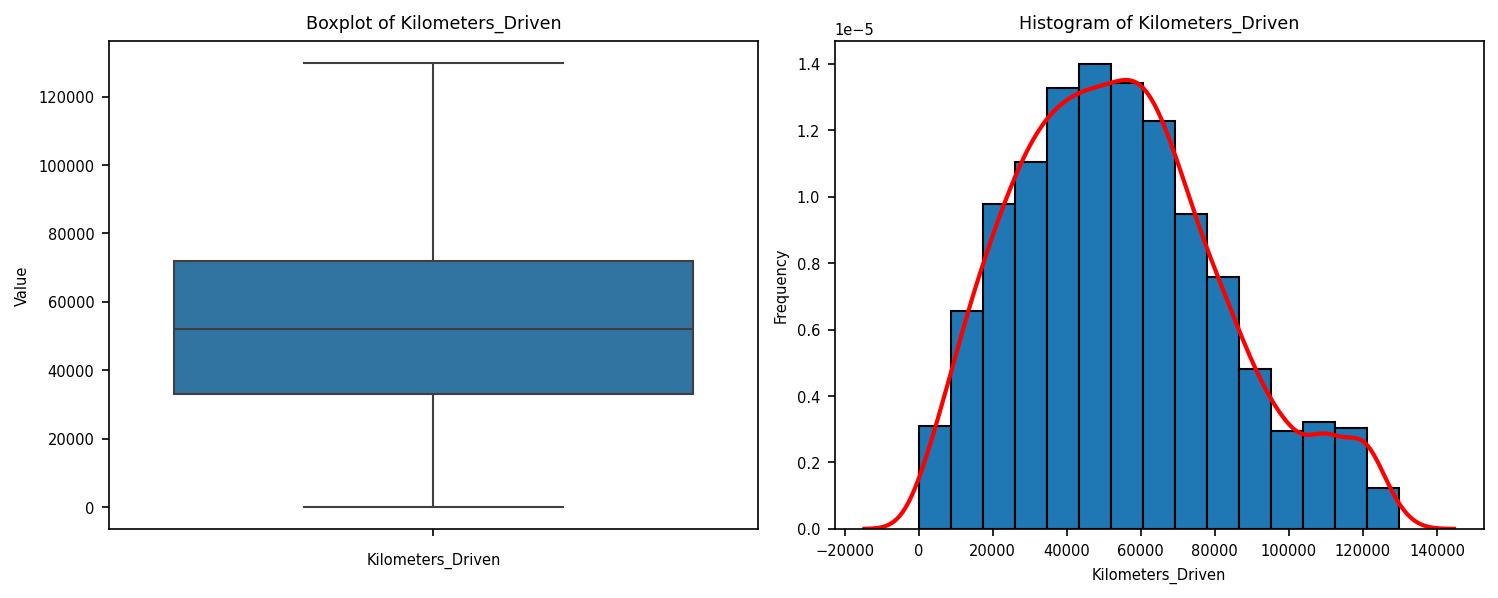

Tổng quan về outlier của cột Kilometers_Driven
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [24]:
df = df.drop(df[df["Kilometers_Driven"] > 129868.12].index).reset_index(drop=True)
box_hist(df, "Kilometers_Driven")
col_outlier, range_outlier = count_outliers_col(df, "Kilometers_Driven")
overview_outliers(df, col_outlier, "Kilometers_Driven", range_outlier)

### Mileage

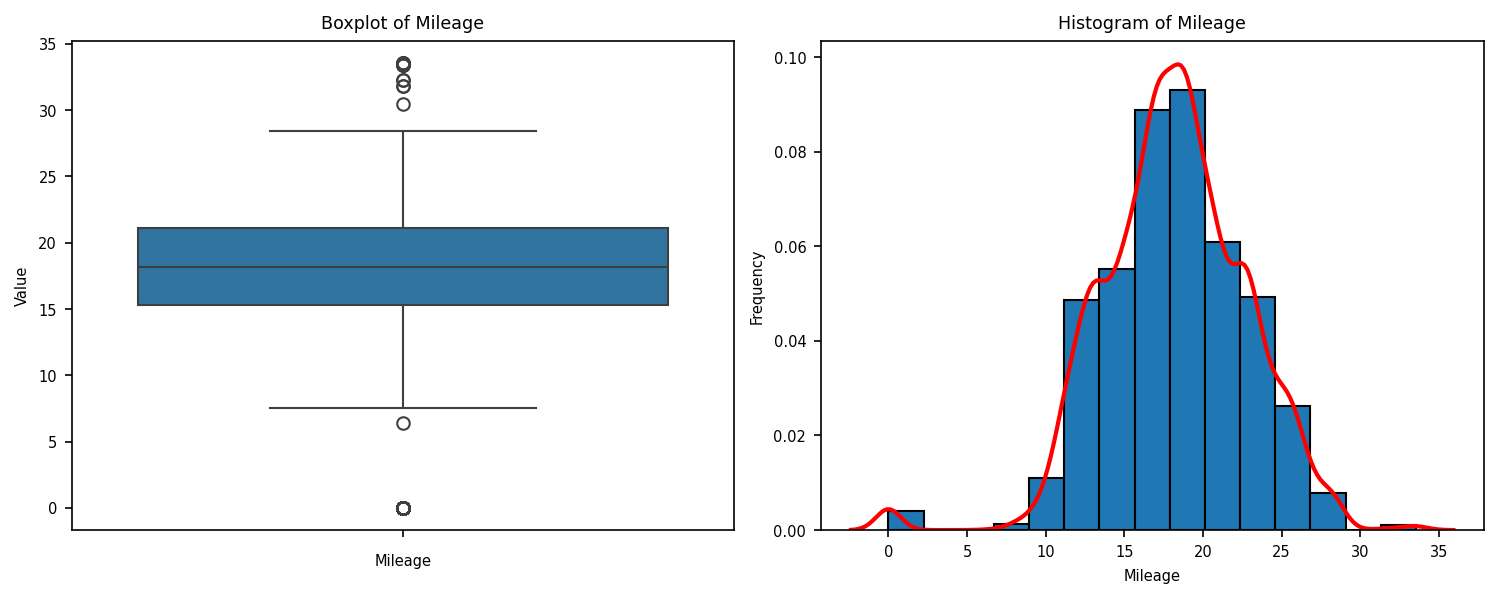

Tổng quan về outlier của cột Mileage
Số lượng outlier: 66
Khoảng outlier: [0.0, 6.57) ∪ (29.82, 33.54]
Tỷ lệ % của outlier so với tập dữ liệu: 1.14%


In [25]:
box_hist(df, "Mileage")
col_outlier, range_outlier = count_outliers_col(df, "Mileage")
overview_outliers(df, col_outlier, "Mileage", range_outlier)

# value =
# count = (col_outlier["Mileage"] > value).sum()
# per = count / len(col_outlier)
# print(f"Tổng số outlier trong cột > {value}: {count} chiếm tỷ lệ {round(per * 100, 2)}%")

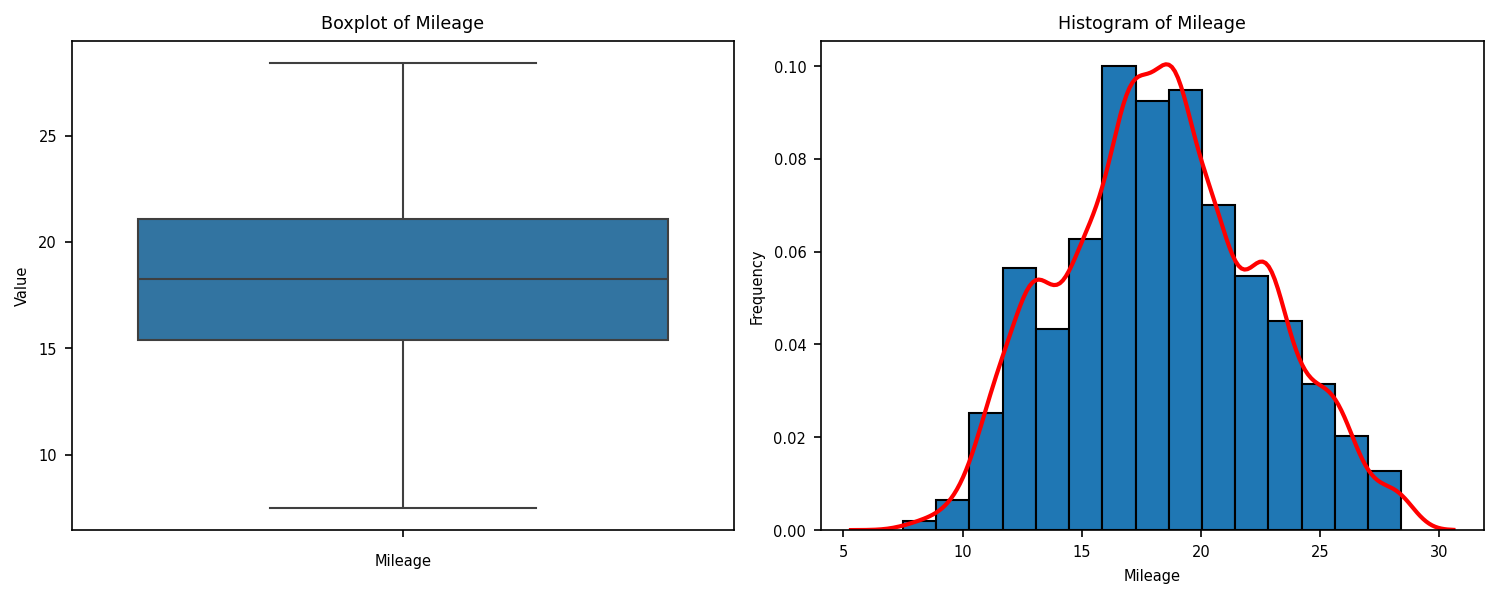

Tổng quan về outlier của cột Mileage
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [26]:
# col_outlier của Mileage
df = df.drop(index=col_outlier.index).reset_index(drop=True)

box_hist(df, "Mileage")
col_outlier, range_outlier = count_outliers_col(df, "Mileage")
overview_outliers(df, col_outlier, "Mileage", range_outlier)

### Engine

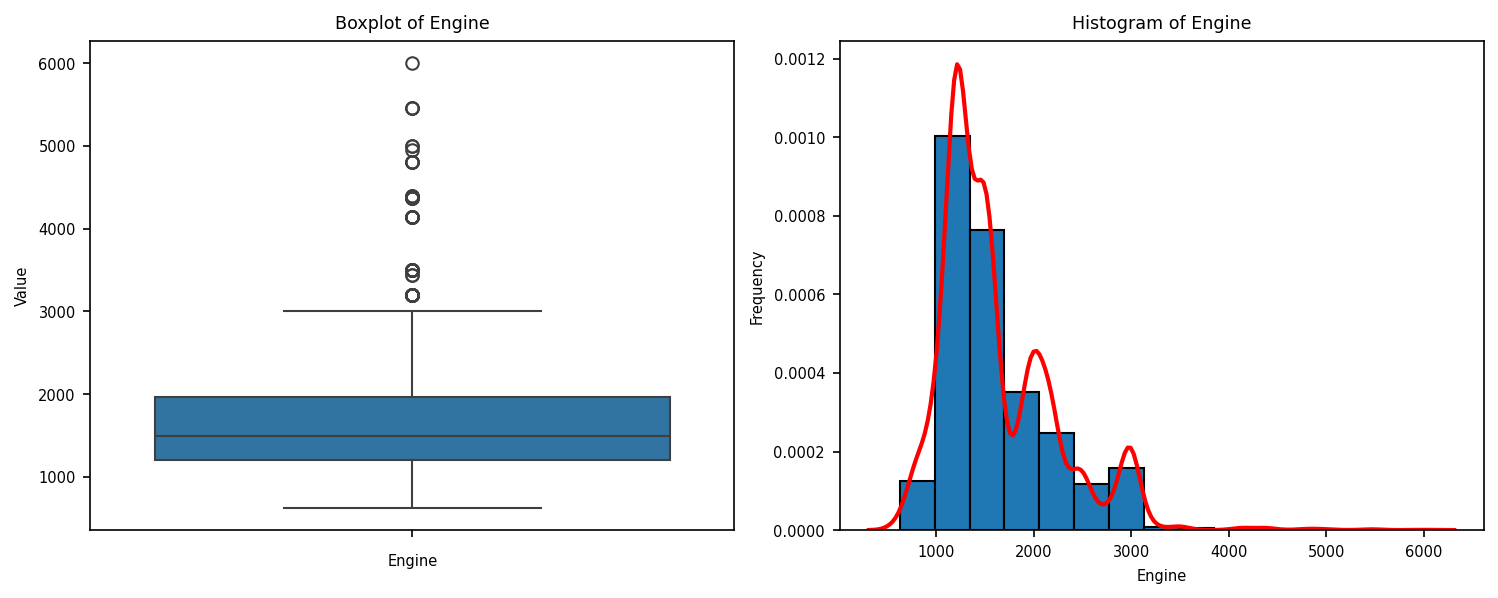

Tổng quan về outlier của cột Engine
Số lượng outlier: 57
Khoảng outlier: (3123.0, 5998.0]
Tỷ lệ % của outlier so với tập dữ liệu: 1.0%


In [27]:
box_hist(df, "Engine")
col_outlier, range_outlier = count_outliers_col(df, "Engine")
overview_outliers(df, col_outlier, "Engine", range_outlier)

# value =
# count = (col_outlier["Engine"] > value).sum()
# per = count / len(col_outlier)
# print(f"Tổng số outlier trong cột > {value}: {count} chiếm tỷ lệ {round(per * 100, 2)}%")

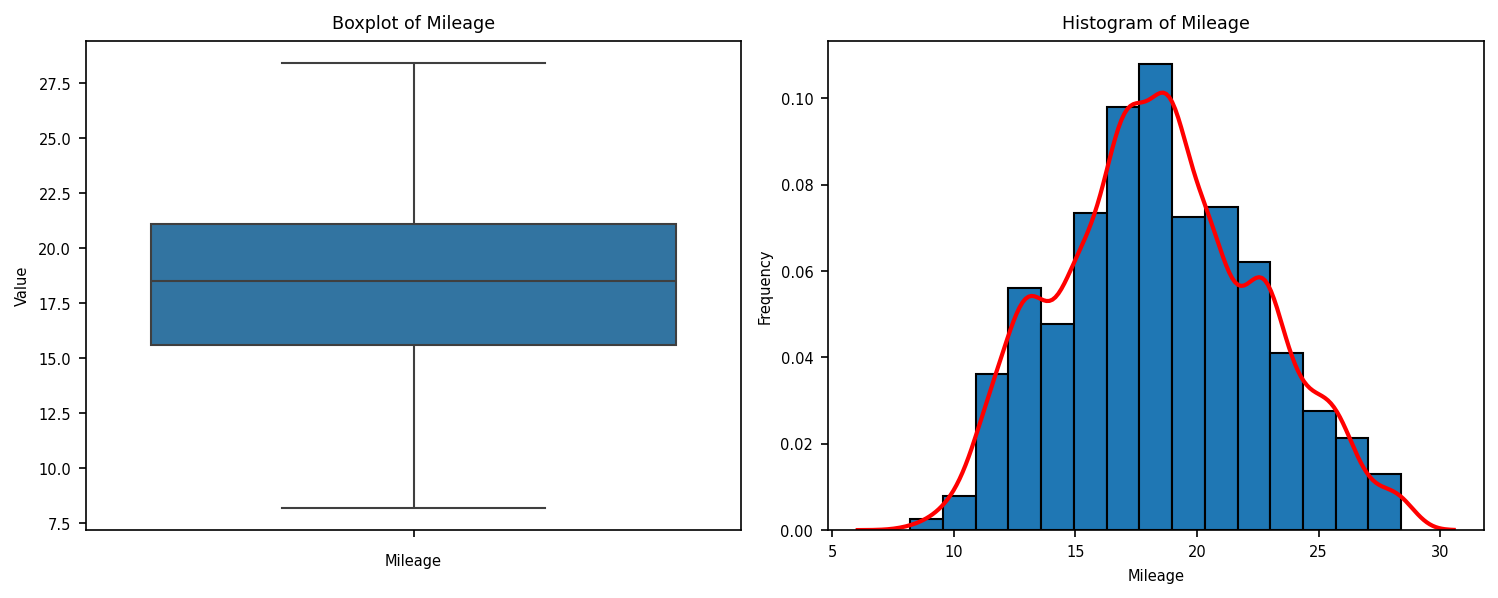

Tổng quan về outlier của cột Mileage
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [28]:
# col_outlier của Engine
df = df.drop(index=col_outlier.index).reset_index(drop=True)

box_hist(df, "Mileage")
col_outlier, range_outlier = count_outliers_col(df, "Mileage")
overview_outliers(df, col_outlier, "Mileage", range_outlier)

### Power

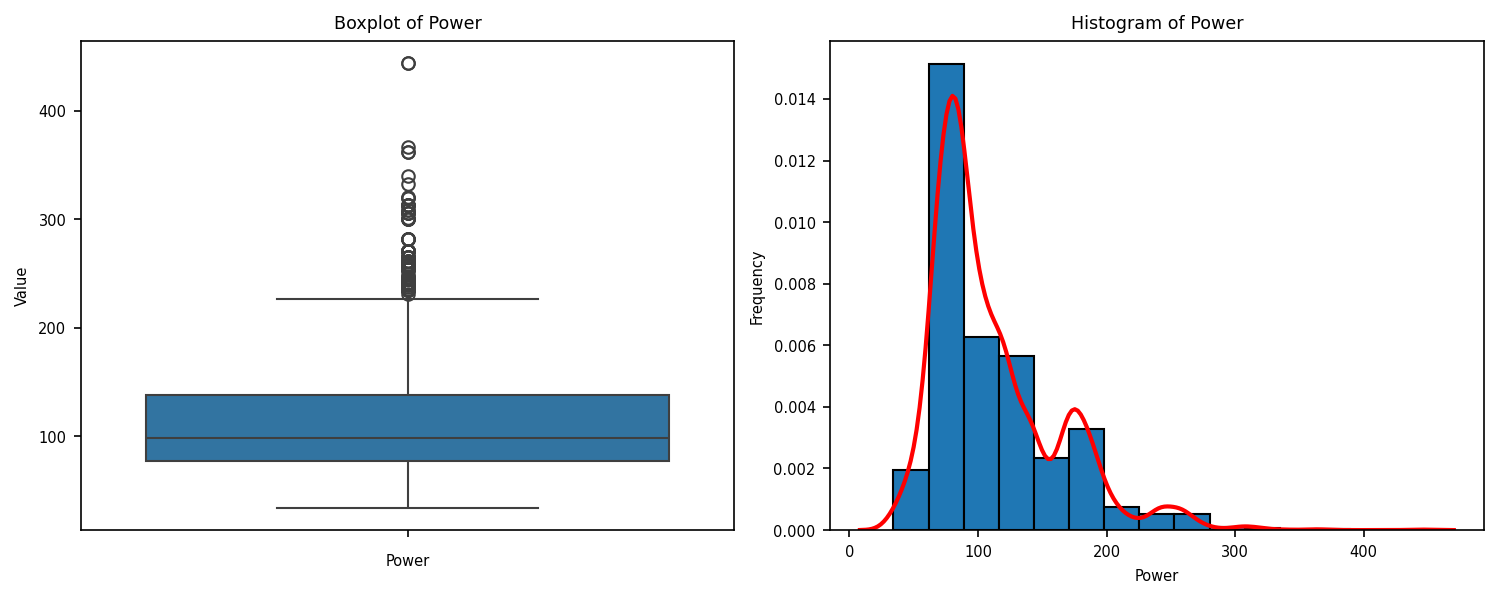

Tổng quan về outlier của cột Power
Số lượng outlier: 193
Khoảng outlier: (229.57, 444.0]
Tỷ lệ % của outlier so với tập dữ liệu: 3.4%


In [29]:
box_hist(df, "Power")
col_outlier, range_outlier = count_outliers_col(df, "Power")
overview_outliers(df, col_outlier, "Power", range_outlier)

# value =
# count = (col_outlier["Power"] > value).sum()
# per = count / len(col_outlier)
# print(f"Tổng số outlier trong cột > {value}: {count} chiếm tỷ lệ {round(per * 100, 2)}%")

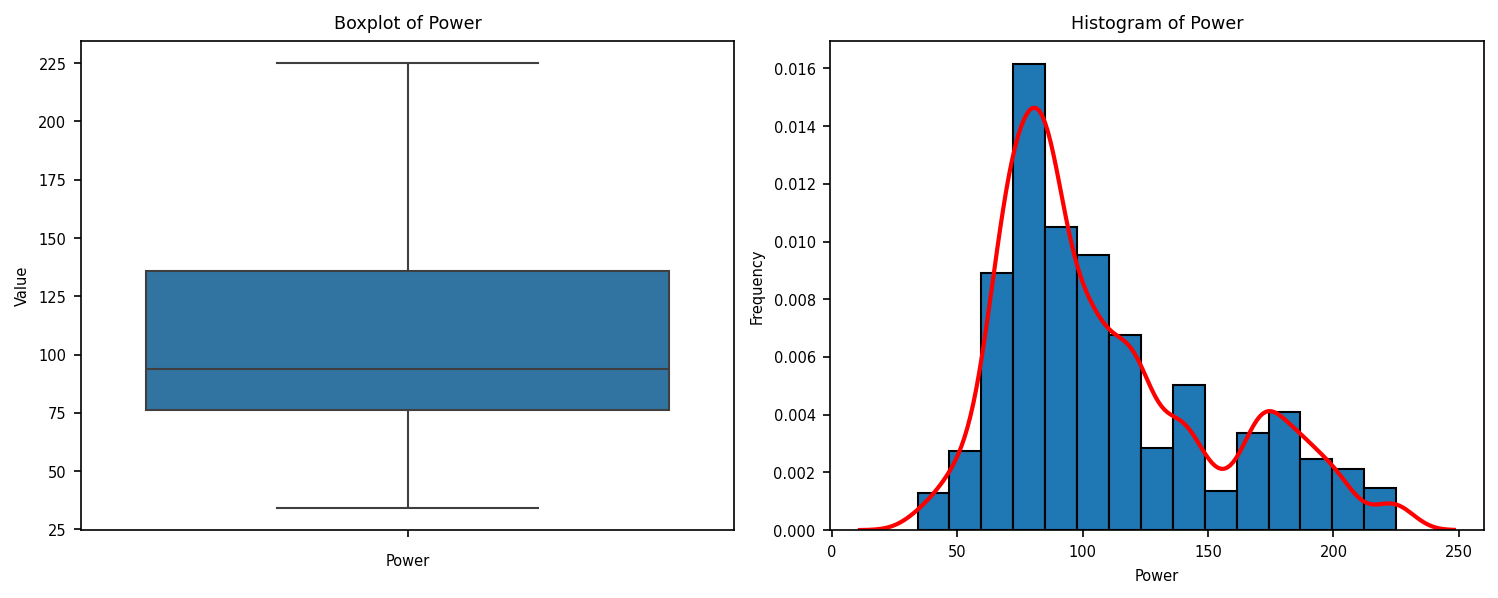

Tổng quan về outlier của cột Power
Số lượng outlier: 0
Khoảng outlier: None
Tỷ lệ % của outlier so với tập dữ liệu: 0.0%


In [30]:
df = df.drop(df[df["Power"] > 270].index).reset_index(drop=True)
df["Power"] = df["Power"].apply(lambda x: 200 if 225 <= x < 250 else
                                225 if 250 <= x else x)

box_hist(df, "Power")
col_outlier, range_outlier = count_outliers_col(df, "Power")
overview_outliers(df, col_outlier, "Power", range_outlier)

### Price

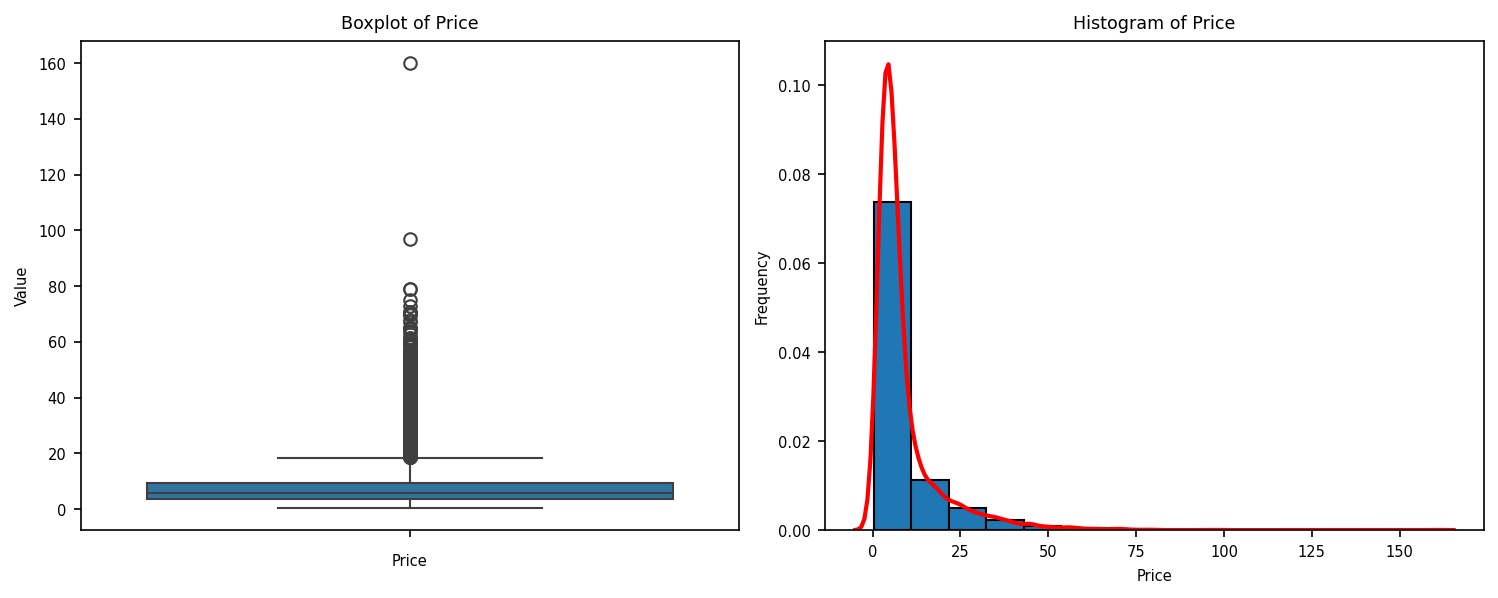

Tổng quan về outlier của cột Price
Số lượng outlier: 657
Khoảng outlier: (18.5, 160.0]
Tỷ lệ % của outlier so với tập dữ liệu: 11.68%
Tổng số outlier trong cột > 50: 55 chiếm tỷ lệ 8.37%


In [31]:
box_hist(df, "Price")
col_outlier, range_outlier = count_outliers_col(df, "Price")
overview_outliers(df, col_outlier, "Price", range_outlier)

value = 50
count = (col_outlier["Price"] > value).sum()
per = count / len(col_outlier)
print(f"Tổng số outlier trong cột > {value}: {count} chiếm tỷ lệ {round(per * 100, 2)}%")

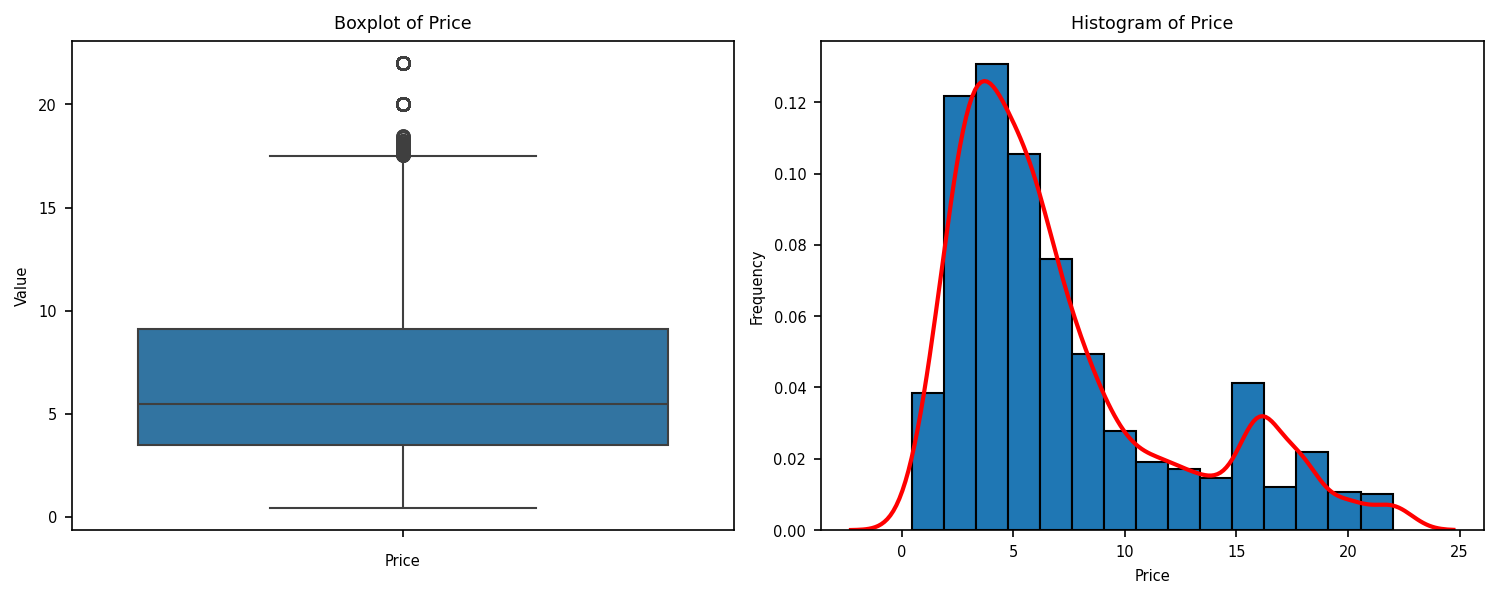

Tổng quan về outlier của cột Price
Số lượng outlier: 344
Khoảng outlier: (17.5, 22.0]
Tỷ lệ % của outlier so với tập dữ liệu: 6.25%


In [32]:
df = df.drop(df[df["Price"] > 40].index).reset_index(drop=True)
df["Price"] = df["Price"].apply(lambda x: 16 if 18.5 <= x < 25 else
                                18 if 25 <= x < 30 else
                                20 if 30 <= x < 35 else
                                22 if 35 <= x <= 40 else x)

box_hist(df, "Price")
col_outlier, range_outlier = count_outliers_col(df, "Price")
overview_outliers(df, col_outlier, "Price", range_outlier)

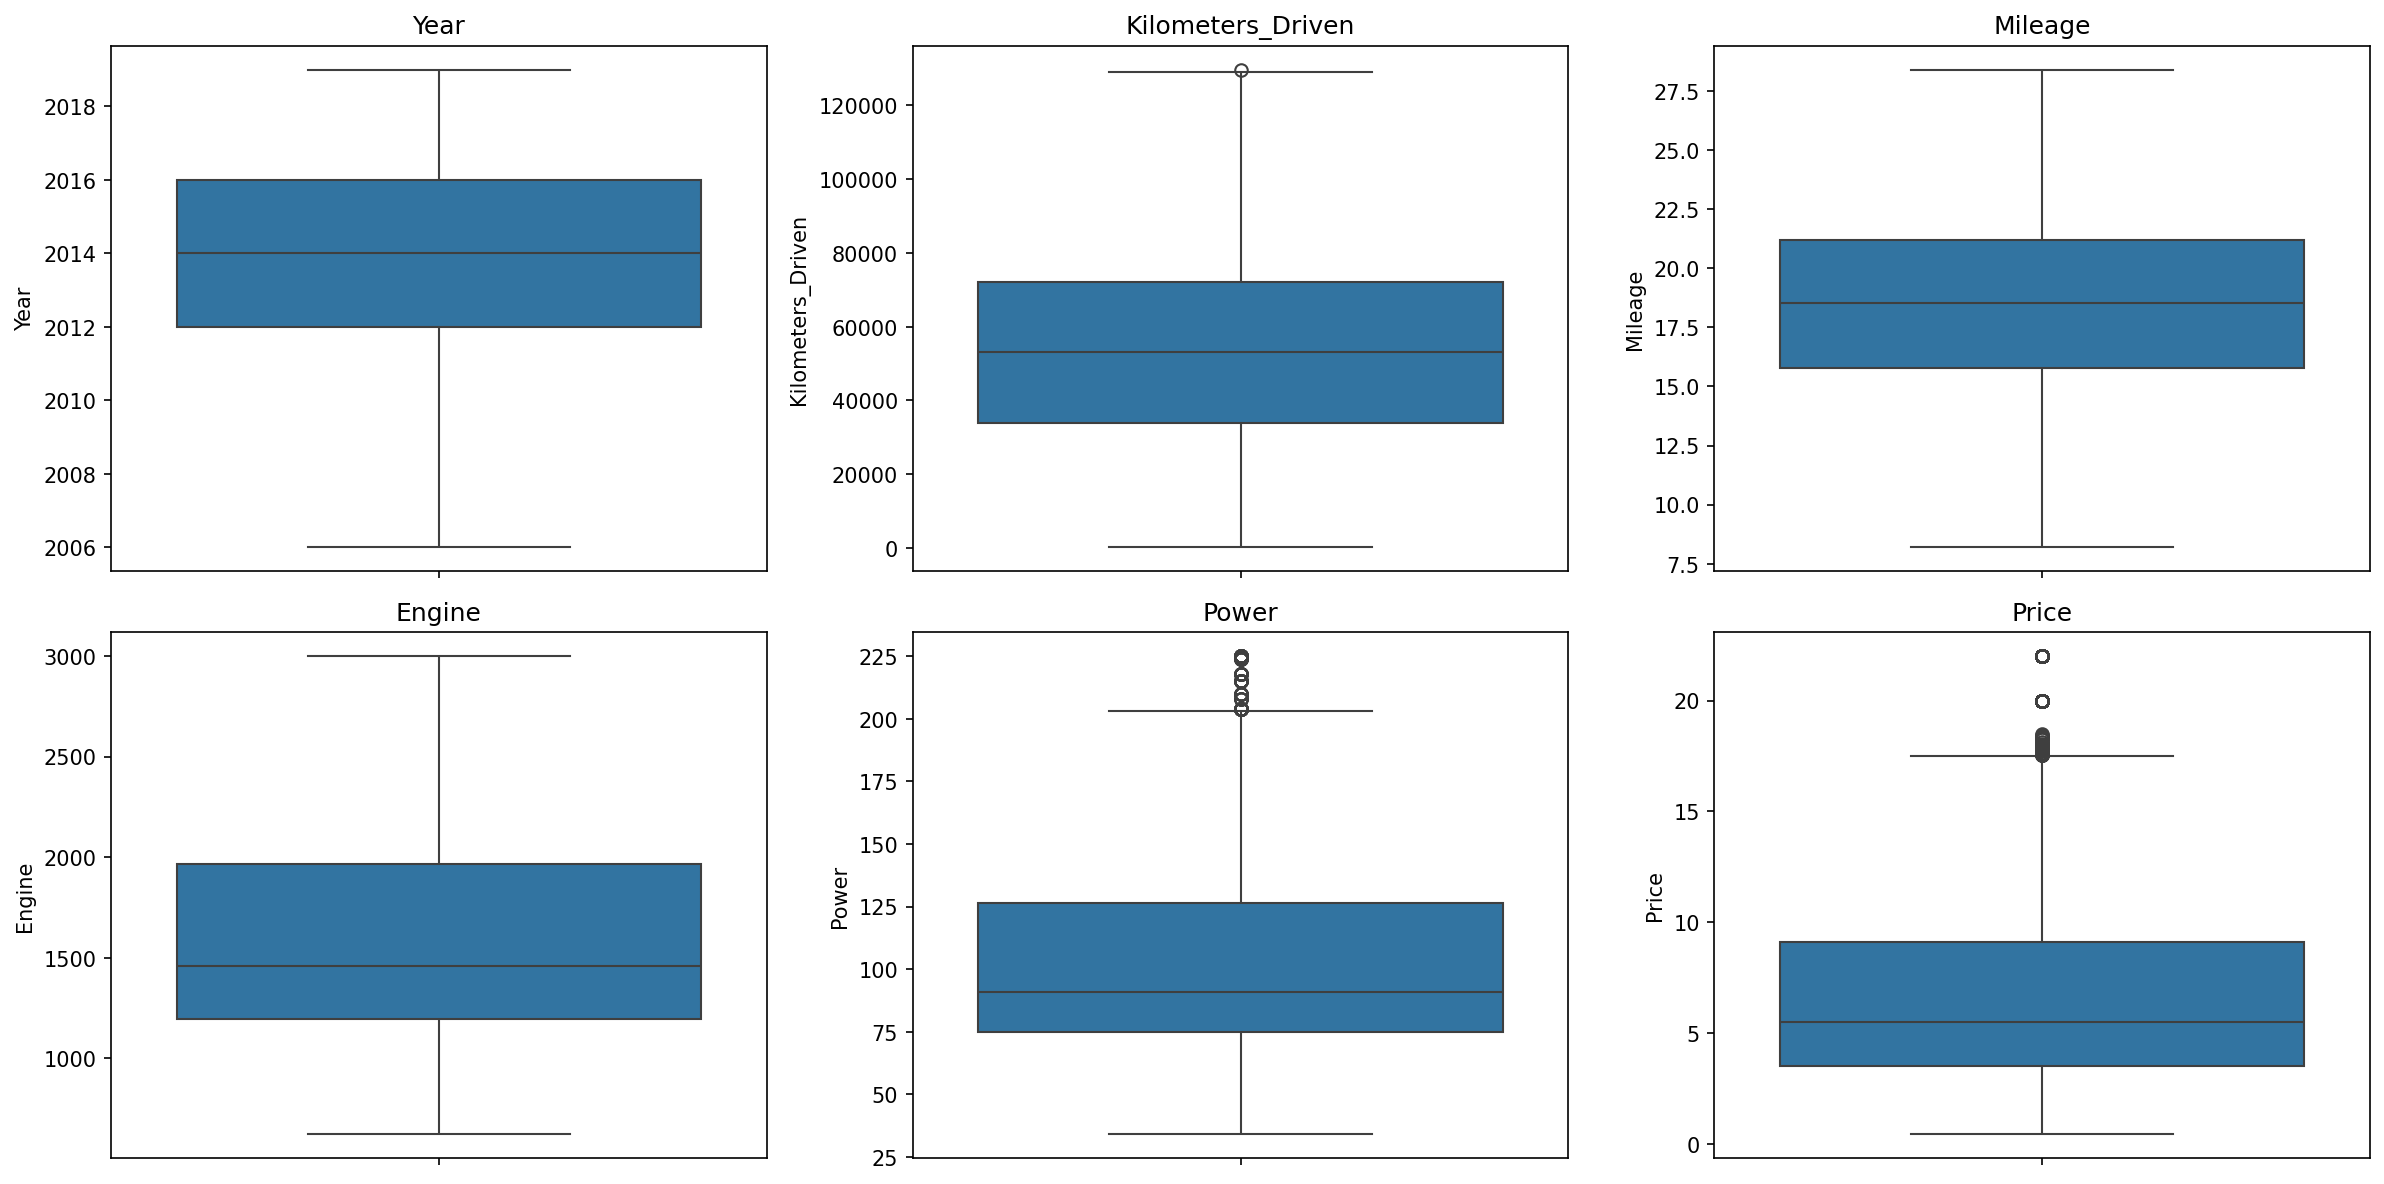

Tổng số outlier trừ cột Seats, No. of Doors là 389, tỷ lệ 7.06%


In [33]:
cont_cols_ = ["Year", "Kilometers_Driven", "Mileage", "Engine", "Power", "Price"]
boxplots(df, cont_cols_, 3)
df_ol = find_outliers(df, cont_cols_)
print(f"Tổng số outlier trừ cột Seats, No. of Doors là {len(df_ol)}, tỷ lệ {round(len(df_ol) / len(df) * 100, 2)}%")

## Chọn đặc trưng

In [34]:
df_selected = df[["Year", "Mileage", "Power", "Engine", "Name", "Fuel_Type", "Transmission", "Price"]]

## Mã hoá dữ liệu

In [35]:
cat_cols = df_selected.select_dtypes(include="object").columns
df_selected[cat_cols].describe()

Name Fuel_Type Transmission
count     5507      5507         5507
unique      27         4            2
top     Maruti    Diesel       Manual
freq      1143      2878         4066

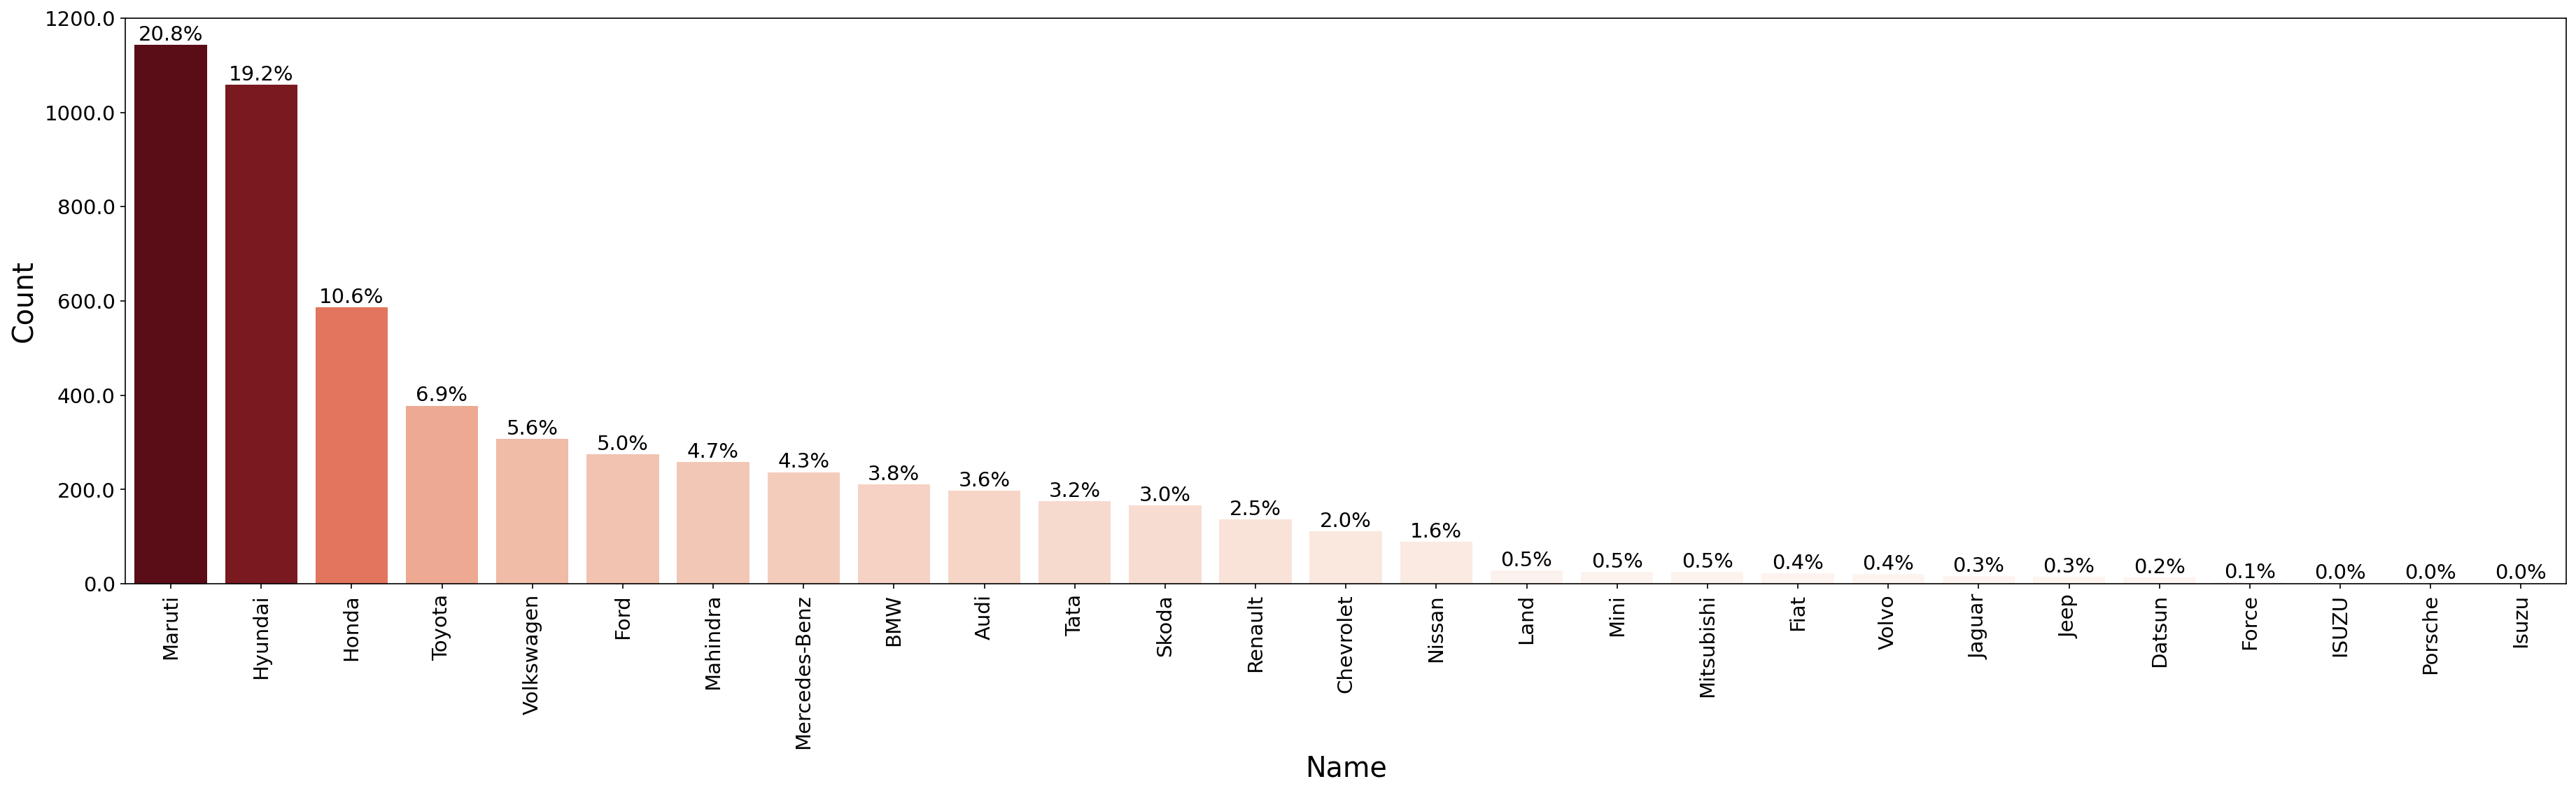

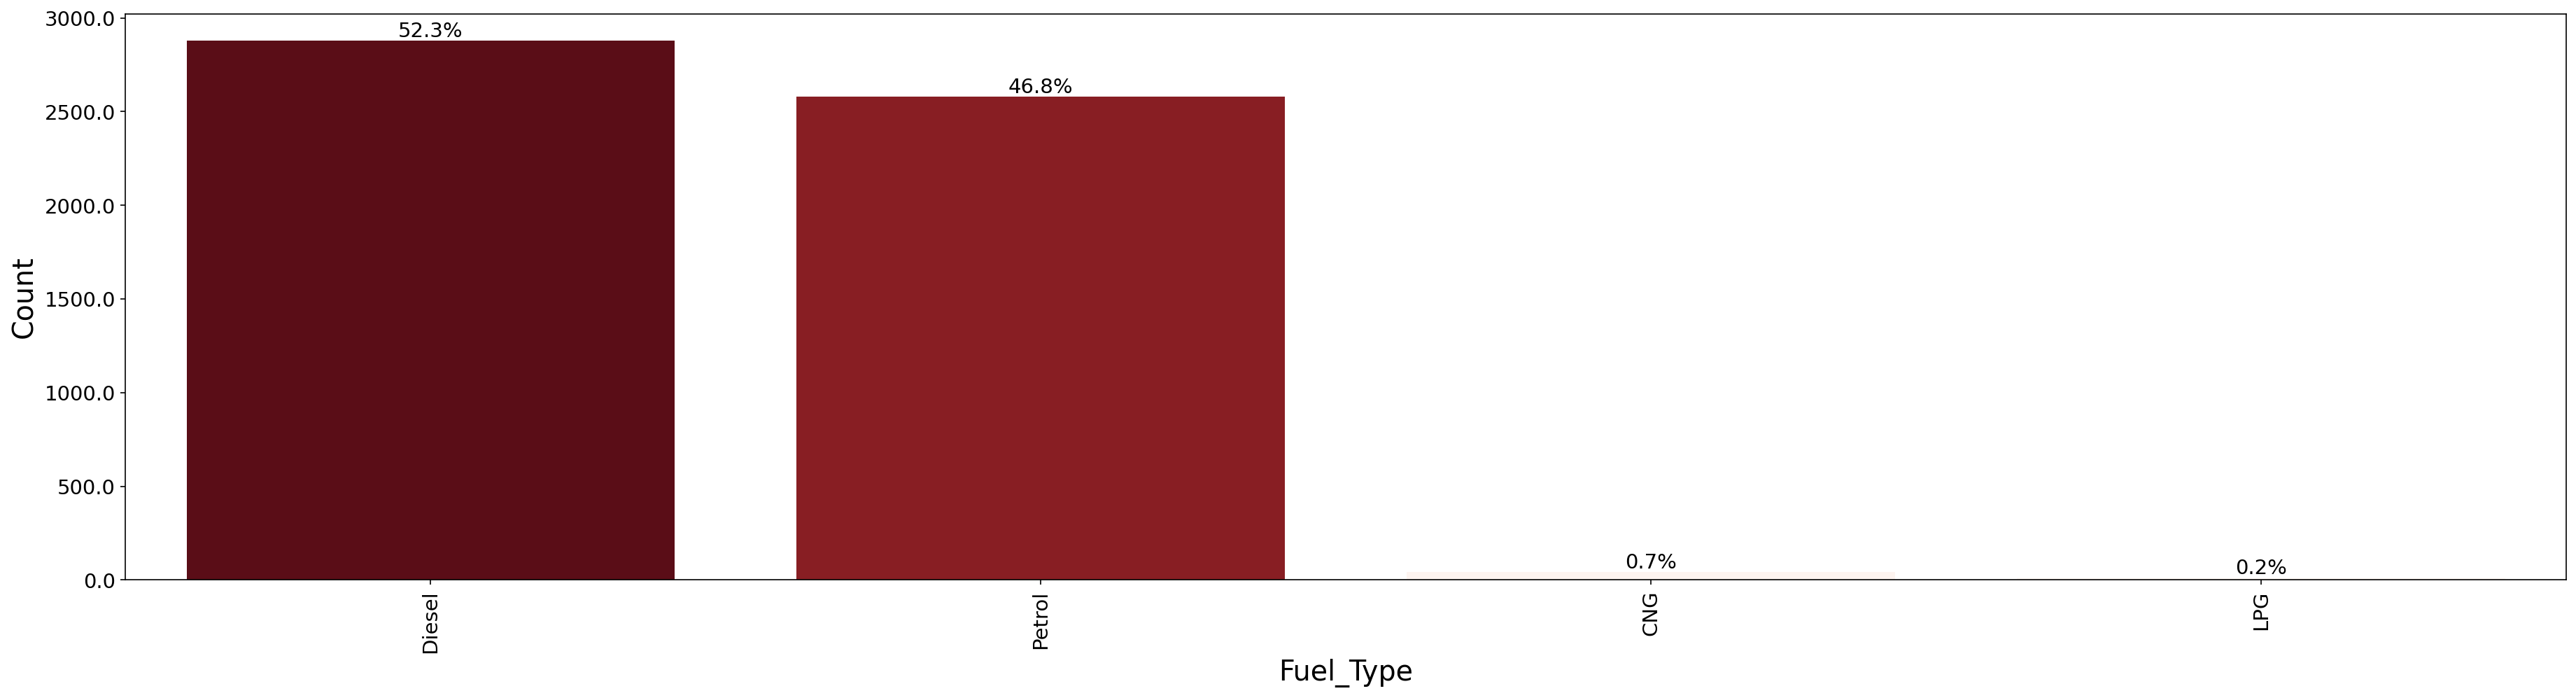

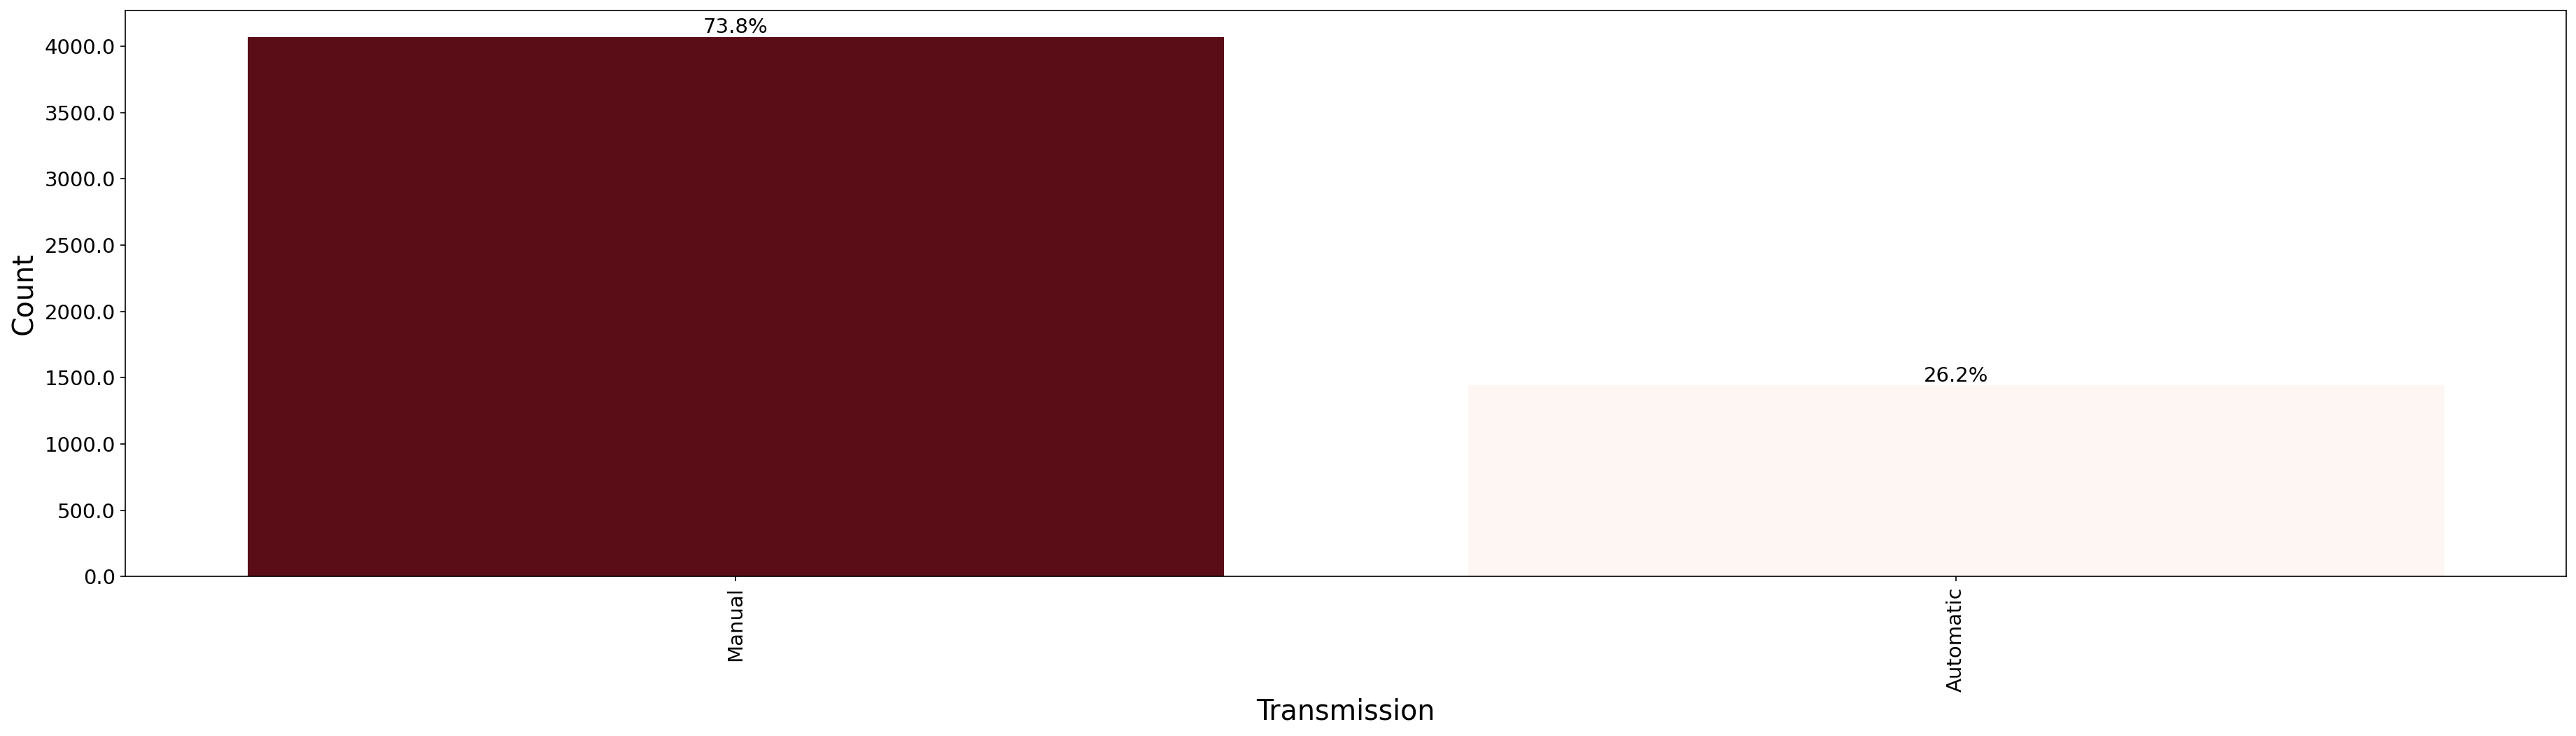

In [36]:
for c in cat_cols:
    plot_category_distribution(df_selected, c, figsize=(30, 7), labelsize=14)

### Fuel_Type

In [37]:
df_avg_Fuel_Type = df_selected.groupby("Fuel_Type", as_index=False)["Price"].mean()
df_avg_Fuel_Type.rename(columns={"Price": "Average_Price"}, inplace=True)
df_avg_Fuel_Type.sort_values(by="Average_Price", ascending=False)

Fuel_Type  Average_Price
1    Diesel       9.223575
3    Petrol       4.975560
0       CNG       3.640244
2       LPG       2.502222

In [38]:
fuel_mapping = {
    "Diesel": 3,
    "Petrol": 2,
    "CNG": 1,
    "LPG": 0
}
df_selected["Fuel_Type"] = df_selected["Fuel_Type"].map(fuel_mapping)

### Name

In [39]:
df_avg_Name = df_selected.groupby("Name", as_index=False)["Price"].mean()
df_avg_Name.rename(columns={"Price": "Average_Price"}, inplace=True)
df_avg_Name.sort_values(by="Average_Price", ascending=False)

Name  Average_Price
20        Porsche      22.000000
11         Jaguar      19.647059
13           Land      18.487500
17           Mini      17.961538
12           Jeep      16.478000
0            Audi      16.416970
10          Isuzu      16.000000
16  Mercedes-Benz      15.980759
1             BMW      15.451469
26          Volvo      15.441429
9           ISUZU      12.045000
24         Toyota      10.759153
18     Mitsubishi      10.499200
5           Force       9.333333
14       Mahindra       8.178721
22          Skoda       7.422036
21        Renault       5.774380
7           Honda       5.470256
8         Hyundai       5.452946
25     Volkswagen       5.262248
6            Ford       5.259382
19         Nissan       4.757753
15         Maruti       4.590919
23           Tata       3.646171
4            Fiat       3.511739
3          Datsun       3.049231
2       Chevrolet       2.939286

In [40]:
def encode_price(avg_price):
    return int(avg_price // 5) + 1  # Mỗi khoảng 5 đơn vị tăng thêm 1 mã

# Thêm cột mã hóa vào df_avg_Name
df_avg_Name["Encoded_Price"] = df_avg_Name["Average_Price"].apply(encode_price)

# Ánh xạ giá trị mã hóa vào df_selected
df_selected["Name"] = df_selected["Name"].map(df_avg_Name.set_index("Name")["Encoded_Price"])

### Transmission

In [41]:
df_avg_Transmission = df_selected.groupby("Transmission", as_index=False)["Price"].mean()
df_avg_Transmission.rename(columns={"Price": "Average_Price"}, inplace=True)
df_avg_Transmission.sort_values(by="Average_Price", ascending=False)

Transmission  Average_Price
0    Automatic      12.389507
1       Manual       5.335935

In [42]:
transmission_mapping = {
    "Automatic": 1,
    "Manual": 0
}
df_selected["Transmission"] = df_selected["Transmission"].map(transmission_mapping)

In [43]:
df_selected

Year  Mileage  Power  Engine  Name  Fuel_Type  Transmission  Price
0     2012.0    12.05  120.0  2179.0     2          3             0   6.00
1     2018.0    21.10  100.0   998.0     1          2             0   8.32
2     2014.0    24.00   70.0  1120.0     2          3             0   3.49
3     2011.0    12.80  102.0  2494.0     3          3             0   6.40
4     2018.0    17.50   88.7  1199.0     2          2             0   9.29
...      ...      ...    ...     ...   ...        ...           ...    ...
5502  2019.0    24.70   69.0  1047.0     1          3             0   7.46
5503  2011.0    13.90  130.3  1799.0     2          2             1   4.50
5504  2013.0    18.50   82.9  1197.0     2          2             0   3.67
5505  2016.0    20.40   81.8  1197.0     1          2             0   5.20
5506  2016.0    20.36   78.9  1197.0     2          2             0   3.60

[5507 rows x 8 columns]

# Huấn luyện, đánh giá mô hình

## Mô hình đơn biến

In [44]:
independent = "Year"
target = "Price"
df_results, saved_models = ln_model(df_selected, independent, target)
save_model("LinearRegression", "LNR-Year", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE Train R2  \
Fold                                                                         
1         3.67      3.7        4.7       4.7      68.32     70.74    14.67   
2         3.63     3.75       4.67      4.84      67.78     69.77    14.85   
3         3.63     3.73       4.67      4.82      68.33     66.71    14.66   
4         3.68     3.61       4.72      4.64      69.25     67.26    14.03   
5         3.71     3.54       4.75      4.52      68.94     68.22    14.46   
Mean      3.66     3.67        4.7       4.7      68.52     68.54    14.53   

     Test R2  
Fold          
1      13.87  
2      13.31  
3      13.82  
4      16.52  
5      14.79  
Mean   14.46

In [45]:
independent = "Mileage"
target = "Price"
df_results, saved_models = ln_model(df_selected, independent, target)
save_model("LinearRegression", "LNR-Mileage", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE Train R2  \
Fold                                                                         
1         3.79     3.78       4.83      4.78       89.4      93.3    10.11   
2         3.76     3.82       4.79      4.93      89.56     87.65    10.38   
3         3.76     3.81       4.81      4.87      89.86     83.51      9.8   
4         3.77     3.84       4.81      4.85      88.82     93.01    10.66   
5         3.82     3.66       4.86      4.66      89.86     90.31     10.4   
Mean      3.78     3.78       4.82      4.82       89.5     89.56    10.27   

     Test R2  
Fold          
1      10.77  
2        9.8  
3      11.74  
4       8.65  
5       9.61  
Mean   10.11

In [46]:
independent = "Power"
target = "Price"
df_results, saved_models = ln_model(df_selected, independent, target)
save_model("LinearRegression", "LNR-Power", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE Train R2  \
Fold                                                                         
1         2.35     2.43       3.12      3.23      49.29     54.86    62.53   
2         2.35     2.42       3.12      3.22      50.23     49.85    61.99   
3         2.37     2.37       3.14      3.14      50.77     46.67    61.52   
4         2.36     2.39       3.13      3.19      49.74     52.09    62.24   
5          2.4     2.22       3.19      2.92       50.9     47.52    61.29   
Mean      2.37     2.37       3.14      3.14      50.19      50.2    61.91   

     Test R2  
Fold          
1      59.32  
2      61.59  
3       63.3  
4      60.58  
5      64.62  
Mean   61.88

In [47]:
independent = "Engine"
target = "Price"
df_results, saved_models = ln_model(df_selected, independent, target)
save_model("LinearRegression", "LNR-Engine", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE Train R2  \
Fold                                                                         
1         2.79     2.79       3.76      3.72      57.64     63.34    45.53   
2         2.79     2.77       3.75      3.75      58.71     56.03    45.09   
3         2.77     2.82       3.73      3.83      58.44     54.62     45.7   
4         2.78     2.81       3.73      3.82      58.26     59.18    46.24   
5          2.8     2.74       3.78      3.63      58.28     58.35    45.81   
Mean      2.79     2.79       3.75      3.75      58.27      58.3    45.67   

     Test R2  
Fold          
1      46.11  
2      47.82  
3      45.38  
4      43.36  
5       45.0  
Mean   45.53

In [48]:
independent = "Power"
target = "Price"
df_results, saved_models = ln_model(df_selected, independent, target)
print(f"Mô hình dự đoán với biến {independent} ở fold {saved_models[3][0]}:\n{saved_models[3][1].summary()}")
df_results


Mô hình dự đoán với biến Power ở fold 4:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     7259.
Date:                Wed, 26 Mar 2025   Prob (F-statistic):               0.00
Time:                        12:52:48   Log-Likelihood:                -11276.
No. Observations:                4406   AIC:                         2.256e+04
Df Residuals:                    4404   BIC:                         2.257e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE Train R2  \
Fold                                                                         
1         2.35     2.43       3.12      3.23      49.29     54.86    62.53   
2         2.35     2.42       3.12      3.22      50.23     49.85    61.99   
3         2.37     2.37       3.14      3.14      50.77     46.67    61.52   
4         2.36     2.39       3.13      3.19      49.74     52.09    62.24   
5          2.4     2.22       3.19      2.92       50.9     47.52    61.29   
Mean      2.37     2.37       3.14      3.14      50.19      50.2    61.91   

     Test R2  
Fold          
1      59.32  
2      61.59  
3       63.3  
4      60.58  
5      64.62  
Mean   61.88

## Mô hình với tất cả các biến

In [ ]:
independent = df_selected.drop(columns=["Price"]).columns
target = "Price"
df_results, saved_models = ln_model(df_selected, independent, target)
save_model("LinearRegression", "LNR-All", saved_models)

df_results

Train MAE Test MAE Train RMSE Test RMSE Train MAPE Test MAPE Train R2  \
Fold                                                                         
1         1.58     1.61        2.0      2.06      35.94     35.09     84.6   
2         1.58     1.59        2.0      2.04       35.7     34.69     84.3   
3         1.59     1.56       2.02       2.0      36.28     32.17    84.13   
4         1.58      1.6       2.01      2.01      35.03     39.27    84.36   
5         1.59     1.58       2.02      1.97      35.74     37.93    84.48   
Mean      1.58     1.59       2.01      2.02      35.74     35.83    84.37   

     Test R2  
Fold          
1      83.39  
2       84.6  
3      85.18  
4      84.34  
5      83.79  
Mean   84.26

In [ ]:
print(f"Mô hình dự đoán với tất cả các biến ở fold {saved_models[2][0]}:\n{saved_models[2][1].summary()}")

Mô hình dự đoán với tất cả các biến ở fold 3:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     3331.
Date:                Tue, 25 Mar 2025   Prob (F-statistic):               0.00
Time:                        08:00:20   Log-Likelihood:                -9340.6
No. Observations:                4406   AIC:                         1.870e+04
Df Residuals:                    4398   BIC:                         1.875e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const 

# Kiểm tra đa cộng tuyến

In [ ]:
vif_results = calculate_vif(df_selected, ["Year", "Mileage", "Power", "Engine"])
vif_results

Feature            VIF
0    const  510263.331473
1     Year       1.155903
2  Mileage       1.899158
3    Power       3.209608
4   Engine       3.682490